# Data Analytics of Football Performance and Predictive Modeling of Match Outcomes
![map_clubs](https://raw.githubusercontent.com/vadimiljin/football/master/map_clubs.png)

Data Analysis Capstone Project @turingcollege

## Introduction

In today's world, data analysis plays a crucial role in various industries, allowing us to gather insights into user behavior, improve technological performance, and even shape ideas for the future. According to market [research](https://www.ibisworld.com/global/market-size/global-sports-betting-lotteries/), the Global Sports Betting & Lotteries Market Size in 2023 is $243.7 billion. As a result, businesses and users alike are increasingly interested in understanding the intricacies of the field to make profitable decisions. With this in mind, my project aims to delve deeper into the world of soccer betting by analyzing given data and using statistical modeling to predict the outcomes of football matches.

Through my analysis, I hope to uncover valuable insights that can help both businesses and users make informed decisions about soccer betting. By examining the data and applying statistical modeling, I aim to gain a deeper understanding of the factors that contribute to successful betting on soccer games.

Ultimately, my goal is to use the power of data analysis to help businesses and users alike make more informed decisions about soccer betting. By providing insights into the world of soccer betting and using statistical modeling to make predictions about match outcomes, I hope to contribute to the growing body of knowledge in this field and help shape its future.


Analysis of data was conducted following provided questions:
1. Which leagues are in which countries?
2. Which leagues score the most/fewest goals?
3. Who are the top scorers in each team and league?
4. Is there such a thing as home advantage?
5. Can I predict how many goals each team will score in each match?
6. Can I predict which team will win the match?

## The data

[Ultimate 25k+ Matches Football Database -European Dataset](https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european) from Kaggle containing data about soccer matches of 11 European countries from seasons 2008 to 2016.

In [178]:
import warnings
from statsmodels.stats.weightstats import ztest
import statsmodels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegressionCV,
    LogisticRegression,
    ElasticNetCV,
)
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.compose import TransformedTargetRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import xml.etree.ElementTree as ET
from IPython.core.interactiveshell import InteractiveShell
from sklearn.multioutput import MultiOutputClassifier
from scipy.stats import chisquare
import scipy.stats as sps
import statsmodels.api as sm
import matplotlib as mpl
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import duckdb as ddb
import pandas as pd
import numpy as np
import sqlite3 as sql

conn = sql.connect("./database.sqlite")


InteractiveShell.ast_node_interactivity = "all"

color = "royalblue"
alpha = 0.5
plt.rcParams["font.family"] = "sans-serif"

warnings.filterwarnings("ignore")
%matplotlib inline


### Loading Data

In [179]:
country_data = pd.read_sql_query("SELECT * FROM Country", conn)
league_data = pd.read_sql_query("SELECT * FROM League", conn)
match_data = pd.read_sql_query("SELECT * FROM Match", conn)
player_data = pd.read_sql_query("SELECT * FROM Player", conn)
player_attributes_data = pd.read_sql_query(
    "SELECT * FROM Player_Attributes", conn)
team_data = pd.read_sql_query("SELECT * FROM Team", conn)
team_attributes_data = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)


### Previewing Data

#### Countries

In [180]:
country_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      11 non-null     int64 
 1   name    11 non-null     object
dtypes: int64(1), object(1)
memory usage: 304.0+ bytes


In [181]:
country_data.head()


,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


#### Leagues

In [182]:
league_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          11 non-null     int64 
 1   country_id  11 non-null     int64 
 2   name        11 non-null     object
dtypes: int64(2), object(1)
memory usage: 392.0+ bytes


In [183]:
league_data.head()


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


#### Matches

In [184]:
match_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25979 entries, 0 to 25978
Columns: 115 entries, id to BSA
dtypes: float64(96), int64(9), object(10)
memory usage: 22.8+ MB


In [185]:
match_data.head()


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


#### Players

In [186]:
player_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11060 entries, 0 to 11059
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  11060 non-null  int64  
 1   player_api_id       11060 non-null  int64  
 2   player_name         11060 non-null  object 
 3   player_fifa_api_id  11060 non-null  int64  
 4   birthday            11060 non-null  object 
 5   height              11060 non-null  float64
 6   weight              11060 non-null  int64  
dtypes: float64(1), int64(4), object(2)
memory usage: 605.0+ KB


In [187]:
player_data.head()


,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


#### Player Attributes

In [188]:
player_attributes_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183978 entries, 0 to 183977
Data columns (total 42 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   183978 non-null  int64  
 1   player_fifa_api_id   183978 non-null  int64  
 2   player_api_id        183978 non-null  int64  
 3   date                 183978 non-null  object 
 4   overall_rating       183142 non-null  float64
 5   potential            183142 non-null  float64
 6   preferred_foot       183142 non-null  object 
 7   attacking_work_rate  180748 non-null  object 
 8   defensive_work_rate  183142 non-null  object 
 9   crossing             183142 non-null  float64
 10  finishing            183142 non-null  float64
 11  heading_accuracy     183142 non-null  float64
 12  short_passing        183142 non-null  float64
 13  volleys              181265 non-null  float64
 14  dribbling            183142 non-null  float64
 15  curve            

In [189]:
player_attributes_data.head()


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


#### Teams

In [190]:
team_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                299 non-null    int64  
 1   team_api_id       299 non-null    int64  
 2   team_fifa_api_id  288 non-null    float64
 3   team_long_name    299 non-null    object 
 4   team_short_name   299 non-null    object 
dtypes: float64(1), int64(2), object(2)
memory usage: 11.8+ KB


In [191]:
team_data.head()


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


#### Team attributes

In [192]:
team_attributes_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              1458 non-null   int64  
 1   team_fifa_api_id                1458 non-null   int64  
 2   team_api_id                     1458 non-null   int64  
 3   date                            1458 non-null   object 
 4   buildUpPlaySpeed                1458 non-null   int64  
 5   buildUpPlaySpeedClass           1458 non-null   object 
 6   buildUpPlayDribbling            489 non-null    float64
 7   buildUpPlayDribblingClass       1458 non-null   object 
 8   buildUpPlayPassing              1458 non-null   int64  
 9   buildUpPlayPassingClass         1458 non-null   object 
 10  buildUpPlayPositioningClass     1458 non-null   object 
 11  chanceCreationPassing           1458 non-null   int64  
 12  chanceCreationPassingClass      14

In [193]:
team_attributes_data.head()


,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


The initial stage of data analysis will concentrate on exploring the Match, Players, and Player Attributes tables. The approach taken in this project is to evaluate missing data and outliers in each table separately.

## Exploratory Data Analysis and Data Cleaning

-----
### Which Leagues are in Which Countries?

In [194]:
country_league_data = pd.read_sql_query(
    """
    SELECT c.id AS country_id
	    ,c.NAME AS country_name
	    ,l.id AS league_id
	    ,l.NAME AS league_name
    FROM Country AS c
    LEFT JOIN League AS l ON c.id = l.country_id
    """,
    conn,
)

country_league_data[["country_name", "league_name"]]


,country_name,league_name
0,Belgium,Belgium Jupiler League
1,England,England Premier League
2,France,France Ligue 1
3,Germany,Germany 1. Bundesliga
4,Italy,Italy Serie A
5,Netherlands,Netherlands Eredivisie
6,Poland,Poland Ekstraklasa
7,Portugal,Portugal Liga ZON Sagres
8,Scotland,Scotland Premier League
9,Spain,Spain LIGA BBVA


----
### Which Leagues Score the Most/Fewest Goals?

Missing data inspection for *Match* table:

<AxesSubplot: >

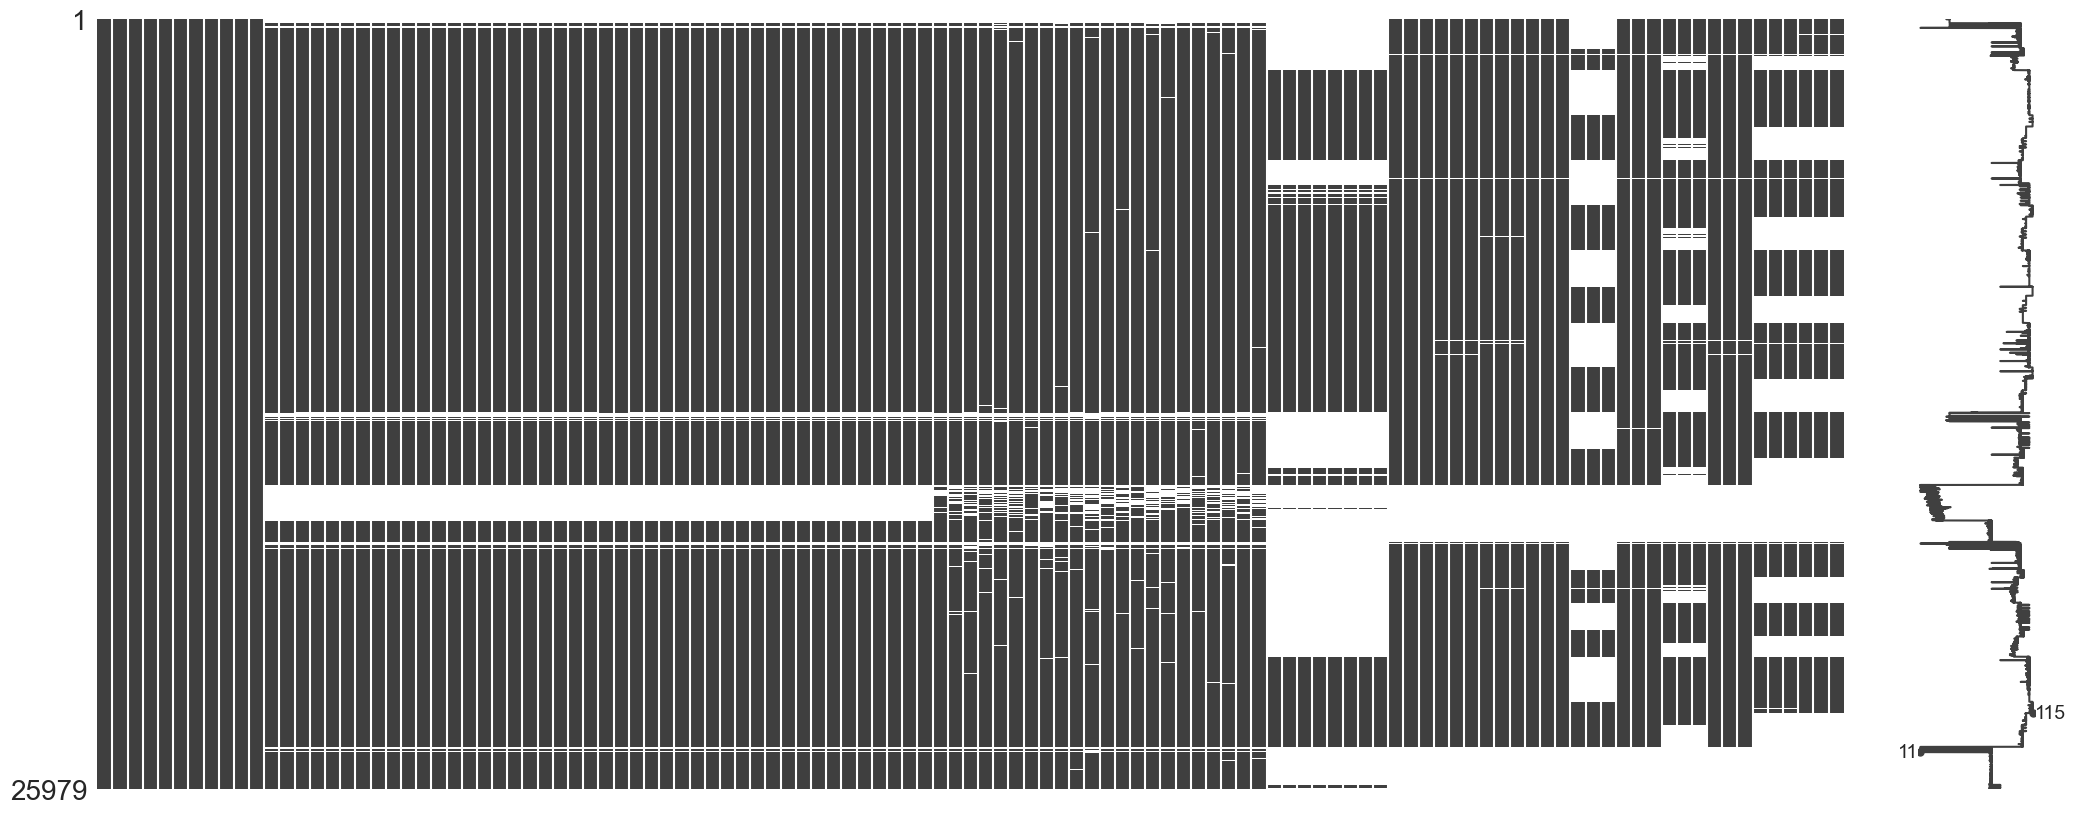

In [195]:
msno.matrix(match_data)

Upon initial inspection of the data, it is evident that certain columns contain missing values. However, for the specific question at hand, only the columns 'home_team_goal', 'away_team_goal', and 'season' will be utilized. Therefore, a closer examination of these columns will be conducted.

In [196]:
match_data[["home_team_goal", "away_team_goal", "season"]].isnull().mean()


home_team_goal    0.0
away_team_goal    0.0
season            0.0
dtype: float64

In [197]:
total_goals_leagues = pd.read_sql_query(
    """
    SELECT m.league_id
	    ,l.NAME
	    ,SUM(m.home_team_goal + m.away_team_goal) AS total_goals
    FROM League AS l
    INNER JOIN Match AS m ON l.id = m.league_id
    GROUP BY 1
    ORDER BY total_goals DESC
    """,
    conn,
)

total_goals_leagues


,league_id,name,total_goals
0,21518,Spain LIGA BBVA,8412
1,1729,England Premier League,8240
2,10257,Italy Serie A,7895
3,13274,Netherlands Eredivisie,7542
4,4769,France Ligue 1,7427
5,7809,Germany 1. Bundesliga,7103
6,17642,Portugal Liga ZON Sagres,5201
7,1,Belgium Jupiler League,4841
8,19694,Scotland Premier League,4804
9,15722,Poland Ekstraklasa,4656


Based on the data provided, it can be inferred that all matches of all leagues between 2008 and 2016 have been recorded. Among these, the Spanish, English, and Italian leagues have the highest number of total goals. Further analysis can be carried out to explore the variation of goals across seasons.

In [198]:
goals_per_season = pd.read_sql_query(
    """
    SELECT m.league_id
	    ,l.NAME
	    ,m.season
	    ,SUM(m.home_team_goal + m.away_team_goal) AS total_goals
    FROM League AS l
    INNER JOIN Match AS m ON l.id = m.league_id
    GROUP BY league_id
	    ,season
    """,
    conn,
)

goals_per_season.groupby("name").agg(goals_avg=("total_goals", "mean")).sort_values(
    by="goals_avg", ascending=False
)


,goals_avg
name,
Spain LIGA BBVA,1051.500
England Premier League,1030.000
Italy Serie A,986.875
Netherlands Eredivisie,942.750
France Ligue 1,928.375
Germany 1. Bundesliga,887.875
Portugal Liga ZON Sagres,650.125
Belgium Jupiler League,605.125
Scotland Premier League,600.500


The average number of goals exhibits the same trend as the overall statistics.

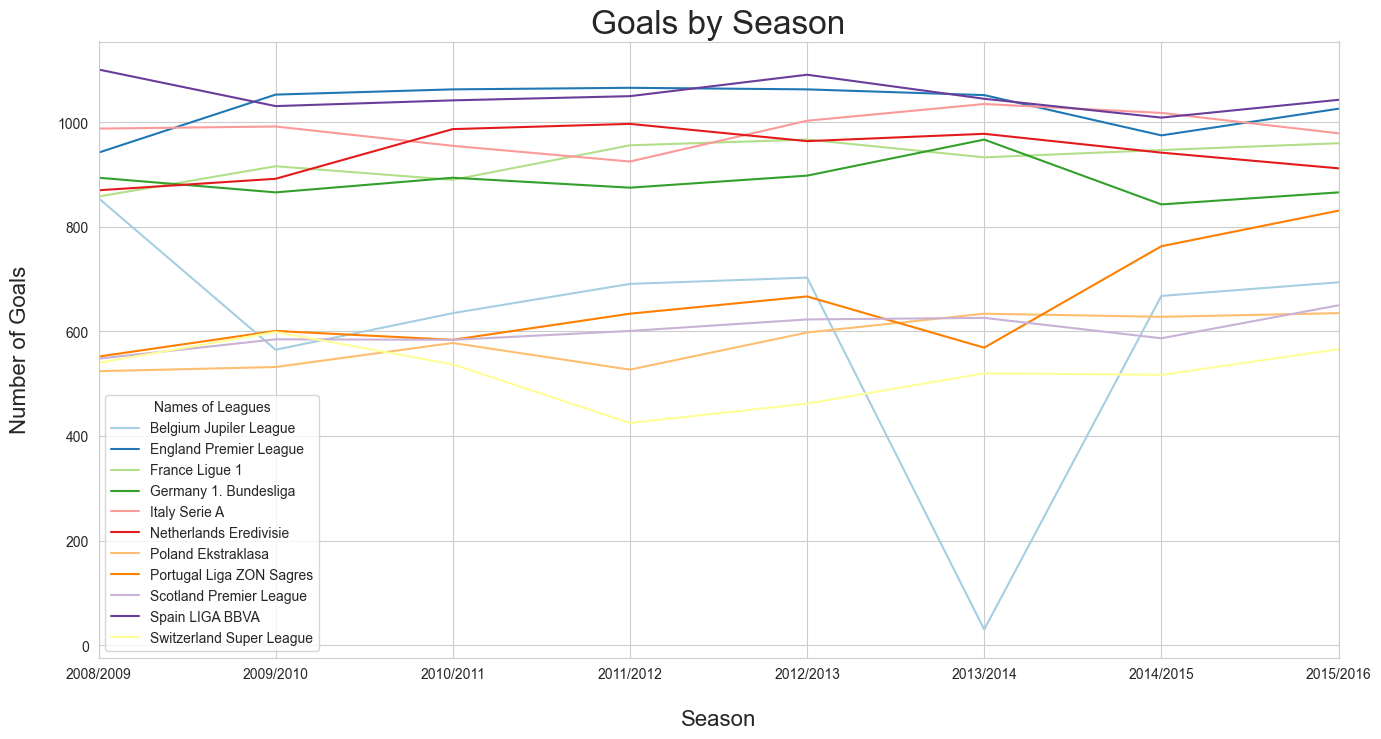

In [199]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.lineplot(
    y=goals_per_season["total_goals"],
    x=goals_per_season.season,
    hue=goals_per_season["name"],
    palette="Paired",
)
plt.xlabel("Season", labelpad=20, size=16)
plt.ylabel("Number of Goals", labelpad=20, size=16)
plt.title("Goals by Season", fontsize=24)
ax.set_xlim("2008/2009", "2015/2016")
plt.legend(title="Names of Leagues")
plt.show();

The trends for each league are apparent except for the Belgium Jupiter League, which experienced an unusually low number of goals in the 2013/2014 season.

In [200]:
len(
    match_data[((match_data["league_id"] == 1) & (
        match_data["season"] == "2013/2014"))]
)


12

As per the analysis, there appears to be a limited number of records available for the Belgium Jupyter league during the season of 2013/2014.

-----
### Analysis of Players Data

<AxesSubplot: >

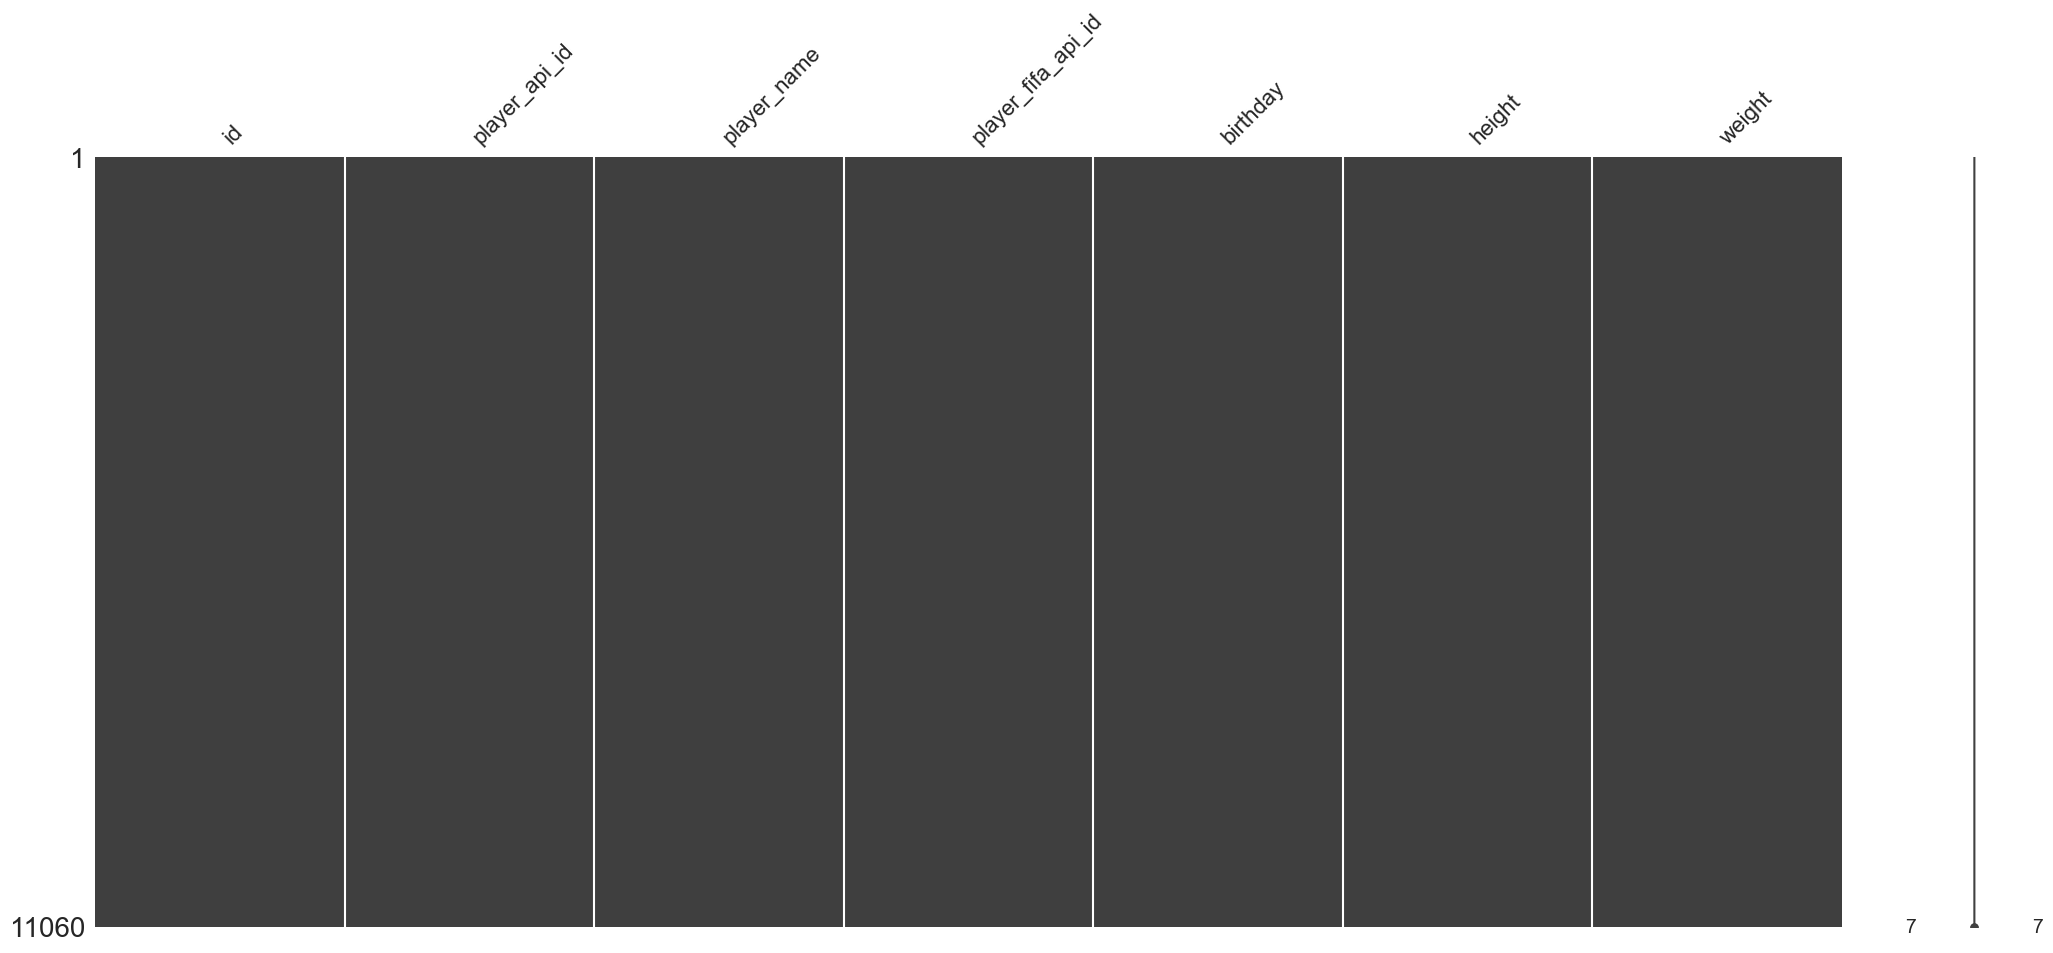

In [201]:
msno.matrix(player_data)


In [202]:
player_data.duplicated(subset=["player_name", "birthday"]).sum()


0

This table pertains to player attributes, including their ID, birthday, and physical parameters of their body. Notably, there are no instances of missing data or duplicates within this table.

In [203]:
# Eliminating redundant columns
player_data = player_data.drop(columns=["id", "player_fifa_api_id"])

player_data.head()


,player_api_id,player_name,birthday,height,weight
0,505942,Aaron Appindangoye,1992-02-29 00:00:00,182.88,187
1,155782,Aaron Cresswell,1989-12-15 00:00:00,170.18,146
2,162549,Aaron Doran,1991-05-13 00:00:00,170.18,163
3,30572,Aaron Galindo,1982-05-08 00:00:00,182.88,198
4,23780,Aaron Hughes,1979-11-08 00:00:00,182.88,154


-----
#### Years of Players' Birth

In [204]:
player_data["birthday"] = pd.DatetimeIndex(player_data["birthday"]).year


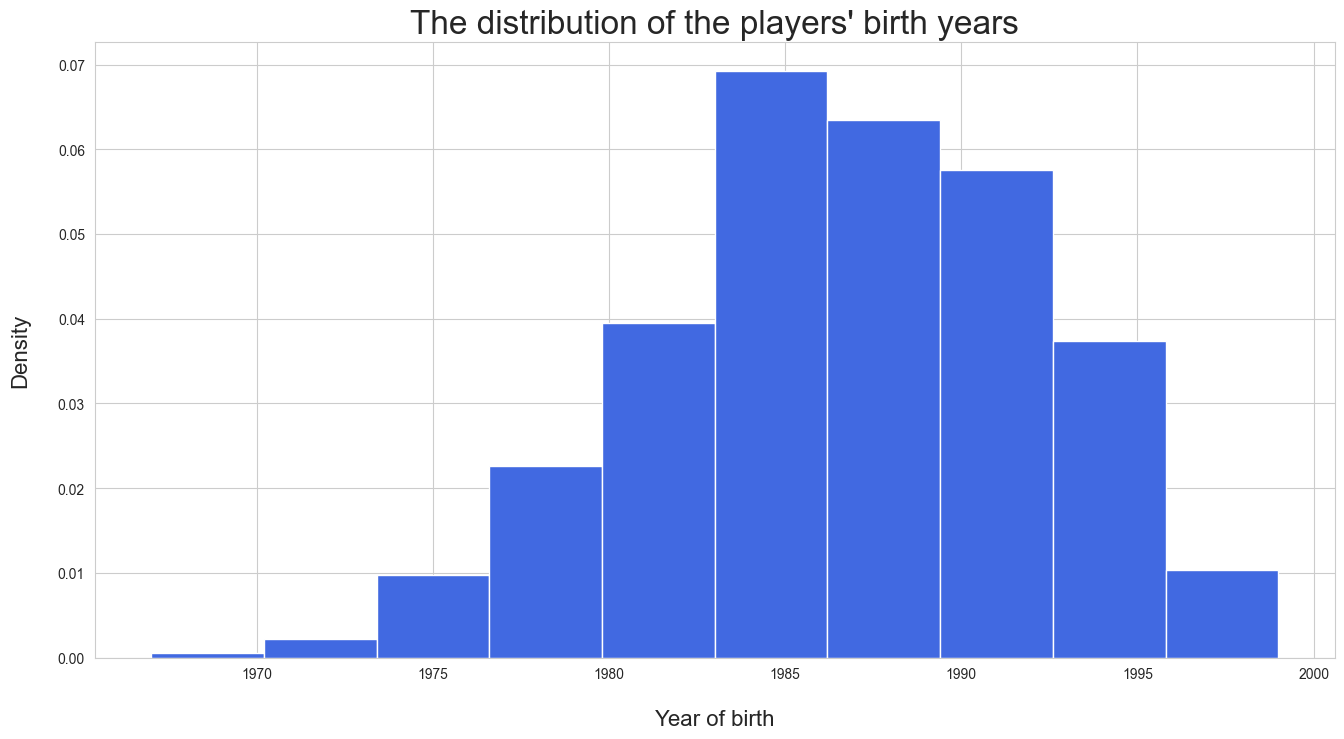

In [205]:
fig, ax = plt.subplots(figsize=(16, 8))
plt.hist(player_data["birthday"], color=color, bins=10, density=True)
plt.xlabel("Year of birth", size=16, labelpad=20)
plt.ylabel("Density", size=16, labelpad=20)
plt.title("The distribution of the players' birth years", size=24)
sns.set_style("whitegrid")
plt.show();

In [206]:
pd.DataFrame(round(player_data["birthday"].describe(), 2)).T


,count,mean,std,min,25%,50%,75%,max
birthday,11060.0,1986.64,5.48,1967.0,1983.0,1987.0,1991.0,1999.0


Based on the available data, it can be observed that the majority of players were born between 1983 and 1991. The oldest player in the dataset was born in 1967, which means that if he played in the 2008 season, he would have been 41 years old, a relatively advanced age for professional sports. On the other hand, the youngest player could have been less than 17 years old. However, it is important to note that the exact time period in which these players played within the 8-year data range is unknown, making it difficult to draw concrete conclusions about their ages.

-----
#### Players' Physical Body Parameters - Height and Weight

In [207]:
# converting weight from lb to kg
player_data["weight"] = player_data["weight"] * 0.45359237


In [208]:
round(player_data[["height", "weight"]].describe().T, 2)


,count,mean,std,min,25%,50%,75%,max
height,11060.0,181.87,6.37,157.48,177.80,182.88,185.42,208.28
weight,11060.0,76.38,6.80,53.07,72.12,76.20,81.19,110.22


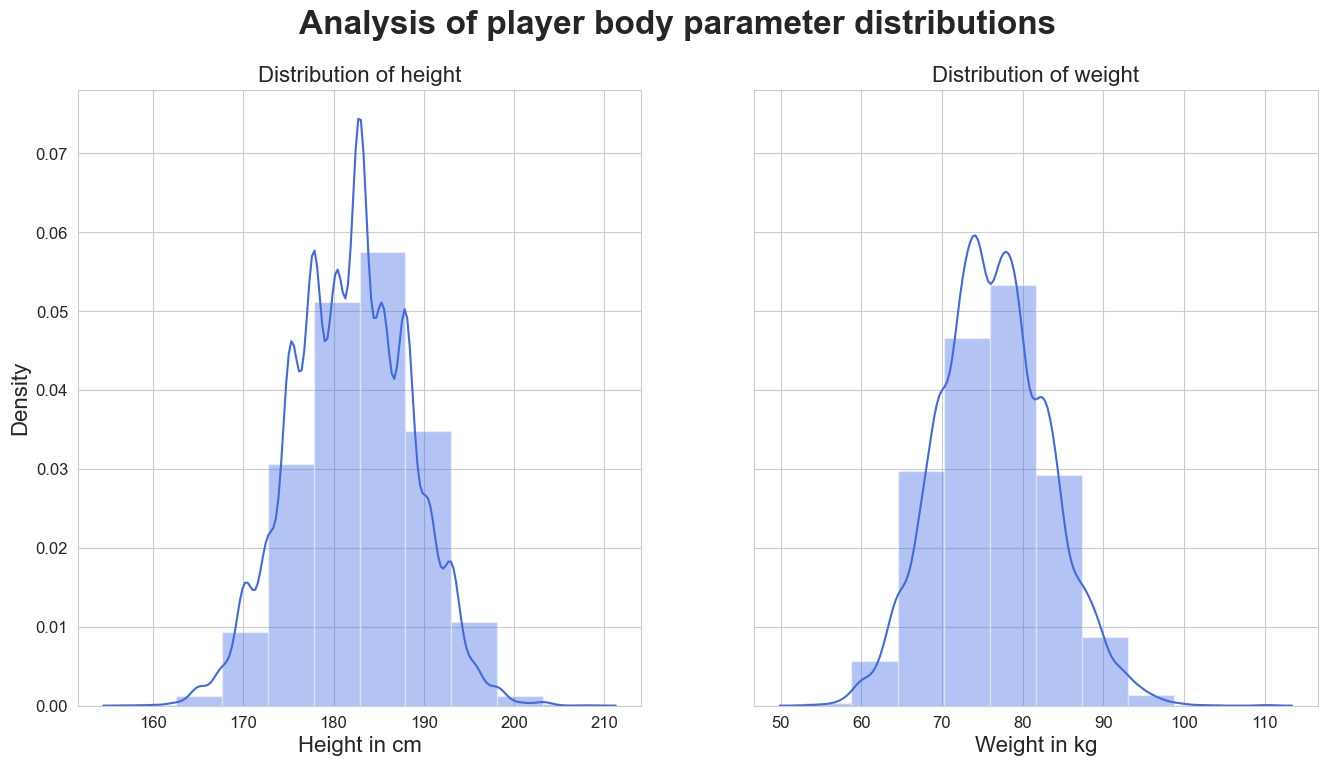

In [209]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(16, 8))

f.suptitle(
    f"Analysis of player body parameter distributions", fontsize=24, weight="bold"
)

sns.distplot(player_data["height"], hist=True, kde=True, ax=ax1, bins=10, color=color)
ax1.set_title("Distribution of height", fontsize=16)
ax1.set_ylabel("Density", fontsize=16)
ax1.set_xlabel("Height in cm", fontsize=16)
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12, visible=True)

sns.distplot(player_data["weight"], hist=True, kde=True, ax=ax2, bins=10, color=color)
ax2.set_title("Distribution of weight", fontsize=16)
ax2.set_xlabel("Weight in kg", fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=12)

plt.show();

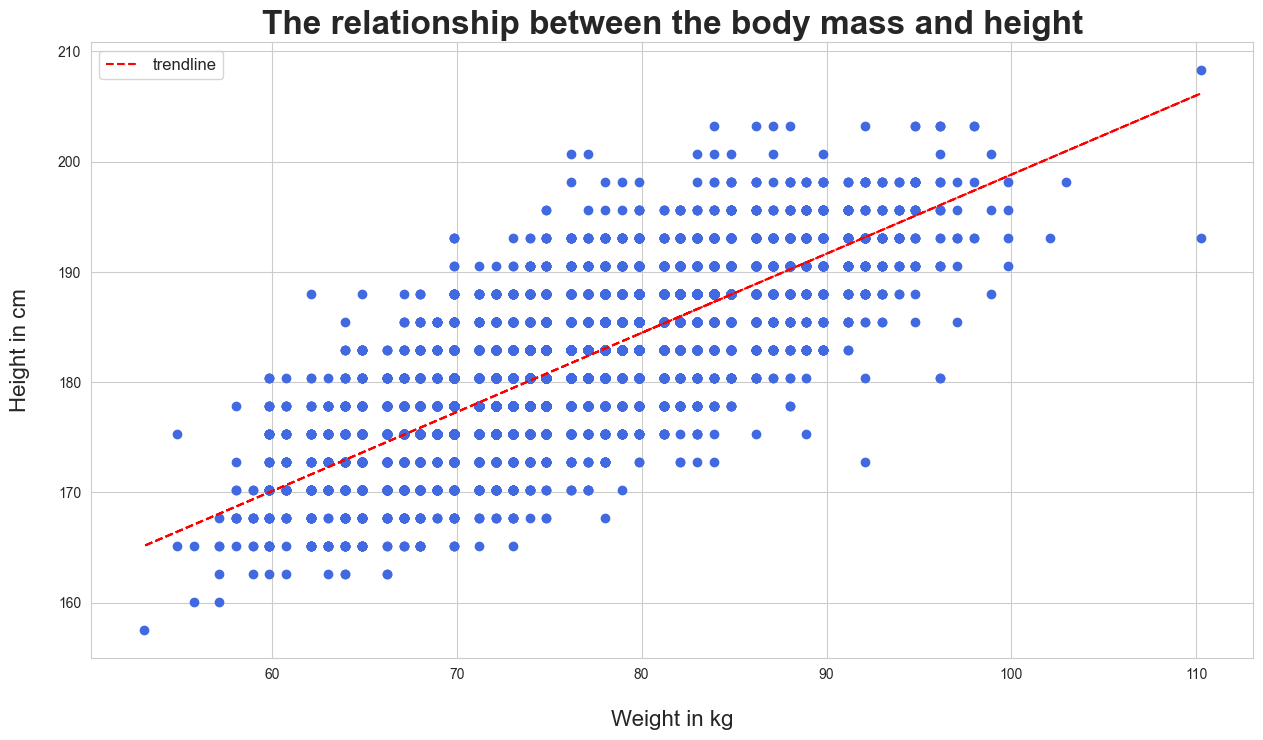

In [210]:
x = player_data["weight"]
y = player_data["height"]

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(x, y, color=color)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label="trendline")

plt.xlabel("Weight in kg", size=16, labelpad=20)
plt.ylabel("Height in cm", size=16, labelpad=20)
plt.title("The relationship between the body mass and height", size=24, weight="bold")
ax.legend(fontsize=12)
plt.show();

The soccer player's physical attributes such as height and weight were analyzed. 

- The average height was found to be approximately 182 cm with a range of 157.48 cm to 208.28 cm, while the majority of players fell between 177 cm and 185 cm. 

- The average weight was 76.4 kg with a range of 53 kg to 110 kg, and most of the players had a weight between 72 kg and 81 kg. 

Additionally, there was a positive correlation observed between body mass and height, as depicted in the plot. It is important to note that the wide range of physical attributes may be beneficial for different player positions. However, the dataset does not provide information on specific positions of the players.

-----
#### Players' Body Mass Index

In [211]:
player_data["BMI"] = round(
    player_data["weight"] / (player_data["height"] / 100) ** 2, 2
)

pd.DataFrame(round(player_data["BMI"].describe(), 2)).T


,count,mean,std,min,25%,50%,75%,max
BMI,11060.0,23.07,1.32,17.59,22.17,23.06,23.87,30.87


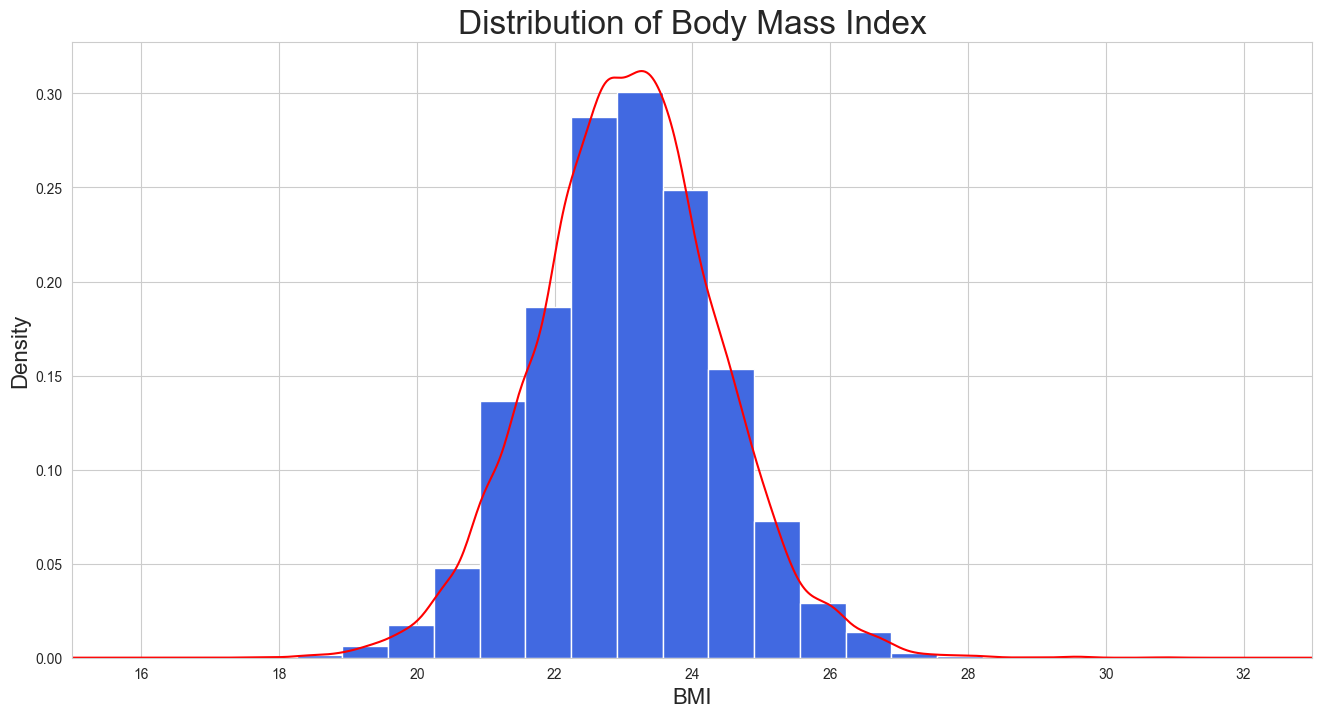

In [212]:
fig, ax = plt.subplots(figsize=(16, 8))

ax.hist(player_data["BMI"], bins=20, density=True, color=color)
bbb = player_data["BMI"].plot.kde(color="r")
ax.set_title("Distribution of Body Mass Index", fontsize=24)
ax.set_ylabel("Density", fontsize=16)
ax.set_xlabel("BMI", fontsize=16)
sns.set_style("whitegrid")
ax.set_xlim(15, 33)

plt.show();

BMI (Body Mass Index) is commonly used as a measure to determine a person's healthy weight. 

Typically, a BMI between 18.5 and 24.9 is considered to be in the healthy range for adults over 20 years old, with lower BMIs indicating underweight and higher BMIs indicating obesity. 

However, there has been some debate regarding the interpretation and accuracy of BMI, particularly when it comes to athletes.

That being said, based on the data I have, it appears that most athletes fall within the healthy BMI range with only a few outliers.

-----
#### Who are the Top Scorers in Each Team and League?

In [213]:
match_data = pd.read_sql_query("SELECT * FROM Match", conn)


In [214]:
# checking for duplicated rows
match_data.duplicated().any().sum()


0

The goal column comprises metadata regarding the match goals, including information about the scoring player and team, the goal type, and so on. However, comprehending this data was quite challenging since it is presented in XML format.

In [215]:
goal_missing = round(match_data["goal"].isnull().mean(), 3)

print("Proportion of missing data in the 'goal' column: ", goal_missing)


Proportion of missing data in the 'goal' column:  0.453


I decided to investigate the amount of missing data in the goal column for each league. This analysis can provide valuable insights for the data interpretation process.

In [216]:
missing_values = (
    match_data.loc[match_data["goal"].isnull()]
    .groupby("country_id")
    .agg(Missing_goal_values=("country_id", "count"))
)

not_missing_values = (
    match_data.loc[match_data["goal"].notnull()]
    .groupby("country_id")
    .agg(Not_missing_goal_values=("country_id", "count"))
)

match_miss_val = (
    league_data.merge(
        missing_values, how="outer", left_on="country_id", right_index=True
    )
    .merge(not_missing_values, how="outer", left_on="country_id", right_index=True)
    .replace(np.nan, 0)
)

match_miss_val[["name", "Missing_goal_values", "Not_missing_goal_values"]].sort_values(
    by="Missing_goal_values"
)


,name,Missing_goal_values,Not_missing_goal_values
1,England Premier League,0.0,3040.0
3,Germany 1. Bundesliga,0.0,2448.0
9,Spain LIGA BBVA,1.0,3039.0
4,Italy Serie A,3.0,3014.0
2,France Ligue 1,1014.0,2026.0
10,Switzerland Super League,1322.0,100.0
0,Belgium Jupiler League,1728.0,0.0
8,Scotland Premier League,1811.0,13.0
6,Poland Ekstraklasa,1913.0,7.0
5,Netherlands Eredivisie,1918.0,530.0


Upon analysis, it is evident that solely the leagues of England and Germany exhibit no null values in the goal column, whereas the leagues of Belgium and Portugal lack information in this column. This insight is valuable for further data interpretation.

Creating new table with data from goal column:

In [217]:
# Obtaining the indices of rows that contain information about the goals scored during matches.
goal_index = list(match_data["goal"][match_data["goal"].notna()].index)
results = []

# Extracting the league ID, team, goal type, and the name of the player who scored
# and appending values to the list of results
for i in goal_index:
    league = match_data["league_id"].loc[i]
    match = match_data["match_api_id"].loc[i]

    root = ET.fromstring(match_data["goal"].loc[i])
    players = root.findall(".//player1")
    teams = root.findall(".//team")
    g_types = root.findall(".//goal_type")

    for i in range(len(players)):
        player = players[i].text
        team = teams[i].text
        g_type = g_types[i].text
        results.append([league, match, player, team, g_type])

goal_data = pd.DataFrame(
    results, columns=["league_id", "match_id",
                      "player1_id", "team_id", "goal_type"]
)

goal_data.head()


,league_id,match_id,player1_id,team_id,goal_type
0,1729,489042,37799,10261,n
1,1729,489042,24148,10260,n
2,1729,489043,26181,9825,n
3,1729,489044,30853,8650,n
4,1729,489045,23139,8654,n


-----
#### Top Scorers

In [218]:
top_scorer_players = ddb.query(
    """
    SELECT t.team_long_name AS team_name
	    ,g.team_id
	    ,p.player_name
	    ,g.player1_id AS player_id
	    ,COUNT(g.player1_id) AS goals
    FROM goal_data AS g
    LEFT JOIN player_data AS p ON g.player1_id = p.player_api_id
    LEFT JOIN team_data AS t ON t.team_api_id = g.team_id
    GROUP BY 1, 2, 3, 4
    ORDER BY 5 DESC
    """
).to_df()

top_scorer_players[["player_name", "goals"]].head(10)


,player_name,goals
0,Lionel Messi,295
1,Cristiano Ronaldo,269
2,Antonio Di Natale,156
3,Wayne Rooney,135
4,Zlatan Ibrahimovic,120
5,Karim Benzema,113
6,Stefan Kiessling,112
7,Sergio Aguero,105
8,Gonzalo Higuain,99
9,Thomas Mueller,94


-----
#### Top Scorers by Team

In [219]:
top_scorer_teams = ddb.query(
    """
    SELECT t.team_long_name AS team_name
	    ,g.team_id
	    ,p.player_name
	    ,g.player1_id AS player_id
	    ,COUNT(g.player1_id) AS goals
    FROM goal_data AS g
    LEFT JOIN player_data AS p ON g.player1_id = p.player_api_id
    LEFT JOIN team_data AS t ON t.team_api_id = g.team_id
    GROUP BY 1, 2, 3, 4
    ORDER BY 5 DESC
    """
).to_df()

top_scorer_teams = (
    top_scorer_teams.groupby(["team_name", "team_id"])
    .first()
    .sort_values(by="goals", ascending=False)
    .reset_index()
)

top_scorer_teams[["team_name", "player_name", "goals"]].head(10)


,team_name,player_name,goals
0,FC Barcelona,Lionel Messi,295
1,Real Madrid CF,Cristiano Ronaldo,269
2,Udinese,Antonio Di Natale,156
3,Manchester United,Wayne Rooney,135
4,Paris Saint-Germain,Zlatan Ibrahimovic,120
5,Bayer 04 Leverkusen,Stefan Kiessling,112
6,Manchester City,Sergio Aguero,105
7,FC Bayern Munich,Thomas Mueller,94
8,FC Schalke 04,Klaas Jan Huntelaar,88
9,Napoli,Edinson Cavani,85


This table contains duplicated names.

In [220]:
top_scorer_teams.shape


(199, 5)

In [221]:
len(top_scorer_teams["player_id"].unique())


194

Based on the shape of the data frames, it can be inferred that certain players were associated with multiple teams.

In [222]:
top_scorer_teams["player_id"].duplicated().sum()


5

In [223]:
# players, who played in more one team
more_than_one_team = top_scorer_teams["player_id"][
    top_scorer_teams["player_id"].duplicated()
].to_list()

top_scorer_teams[top_scorer_teams["player_id"].isin(more_than_one_team)].sort_values(
    by=["player_name"]
)


,team_name,team_id,player_name,player_id,goals
149,AC Ajaccio,8576,Adrian Mutu,39311,11
154,Cesena,9880,Adrian Mutu,39311,10
79,Real Sporting de Gijón,9869,David Barral,41294,28
107,Levante UD,8581,David Barral,41294,19
128,FC Sochaux-Montbéliard,9874,Modibo Maiga,91560,15
155,FC Metz,8550,Modibo Maiga,91560,10
51,SC Freiburg,8358,Papiss Cisse,46700,41
52,Newcastle United,10261,Papiss Cisse,46700,41
29,Valencia CF,10267,Roberto Soldado,37506,59
76,Getafe CF,8305,Roberto Soldado,37506,29


-----
#### Top Scorers by League

In [224]:
top_scorer_leagues = ddb.query(
    """
    SELECT l.NAME AS league_name
	    ,g.league_id
	    ,p.player_name
	    ,g.player1_id AS player_id
	    ,COUNT(g.player1_id) AS goals
    FROM goal_data AS g
    LEFT JOIN player_data AS p ON g.player1_id = p.player_api_id
    LEFT JOIN league_data AS l ON l.id = g.league_id
    GROUP BY 1, 2, 3, 4
    ORDER BY 5 DESC
    """
).to_df()

top_scorer_leagues.groupby(["league_name", "league_id"]).first().sort_values(
    by="goals", ascending=False
)


,,player_name,player_id,goals
league_name,league_id,,,
Spain LIGA BBVA,21518,Lionel Messi,30981,295
Italy Serie A,10257,Antonio Di Natale,27734,156
England Premier League,1729,Wayne Rooney,30829,135
Germany 1. Bundesliga,7809,Robert Lewandowski,93447,124
France Ligue 1,4769,Zlatan Ibrahimovic,35724,120
Netherlands Eredivisie,13274,Luuk de Jong,150201,47
Switzerland Super League,24558,Guillaume Hoarau,37554,17
Scotland Premier League,19694,Kenny Miller,34177,7
Poland Ekstraklasa,15722,Artjoms Rudnevs,79982,3


The majority of names in this table align with top scorers either individually or within teams. However, due to the missing data in the goal column, the lower part of the rating is affected.

In [225]:
top_scorer_leagues.shape


(4938, 5)

In [226]:
len(top_scorer_leagues["player_id"].unique())


4355

There are certain players who are associated with multiple leagues:

In [227]:
top_scorer_leagues[top_scorer_leagues["player_id"] == "30893"]


,league_name,league_id,player_name,player_id,goals
1,Spain LIGA BBVA,21518,Cristiano Ronaldo,30893,270
476,England Premier League,1729,Cristiano Ronaldo,30893,20


-----
#### Players' Rating

<AxesSubplot: >

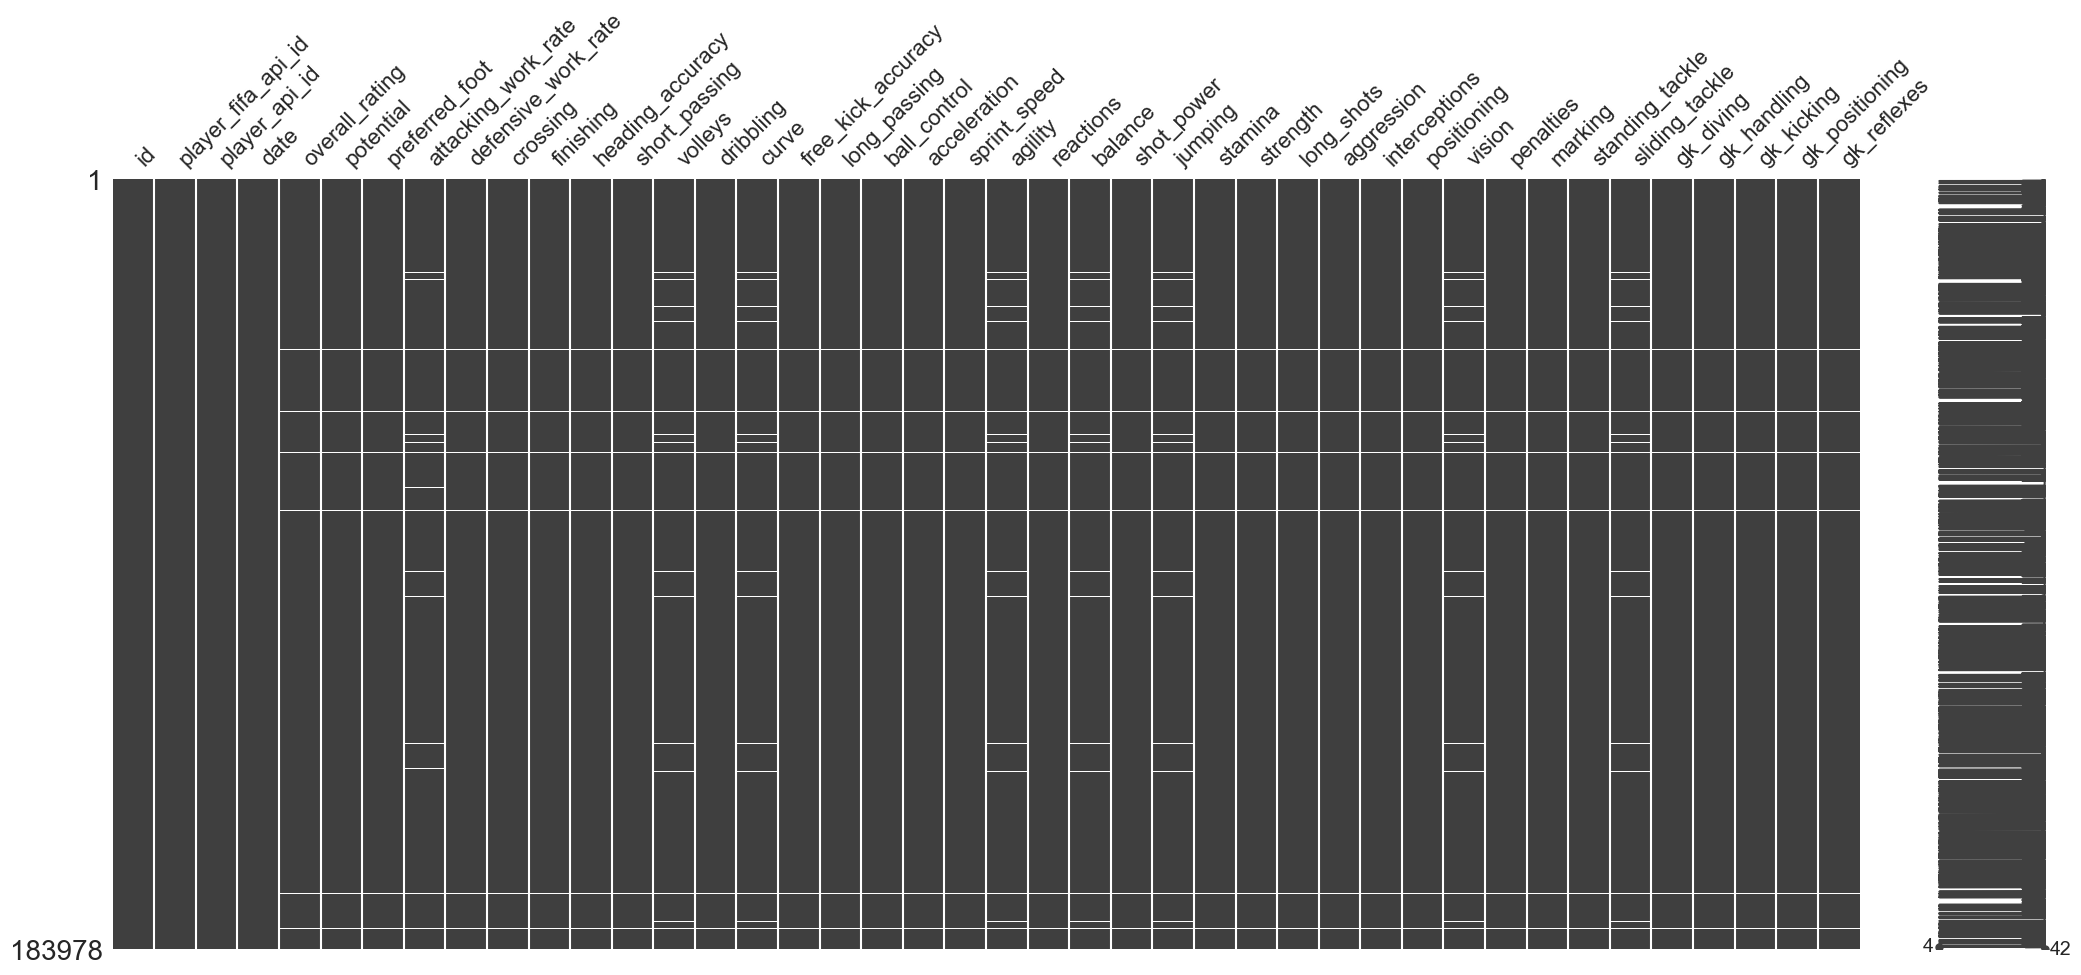

In [228]:
msno.matrix(player_attributes_data)


In [229]:
# converting date columns to date format
player_attributes_data["date"] = pd.to_datetime(player_attributes_data["date"])


In [230]:
# dropping unnecessary columns
player_attributes_data.drop(columns=["player_fifa_api_id", "id"], inplace=True)


The primary variable utilized for subsequent analysis will be the overall rating.

The overall rating comprises of six fundamental criteria: speed, shooting, passing, defending, dribbling, and physicality. 

Each player is given a score for each of these criteria, and these scores are employed to determine an overall rating out of 100. 

Moreover, the coefficient stats for each player differ by 10-15 from those of players who do not perform the same role. These coefficients have differing weights.

In [231]:
# dropping rows with null overall rating values
player_attributes_data = player_attributes_data[
    player_attributes_data["overall_rating"].notnull()
]


In [232]:
pd.DataFrame(player_attributes_data["overall_rating"].describe()).T


,count,mean,std,min,25%,50%,75%,max
overall_rating,183142.0,68.600015,7.041139,33.0,64.0,69.0,73.0,94.0


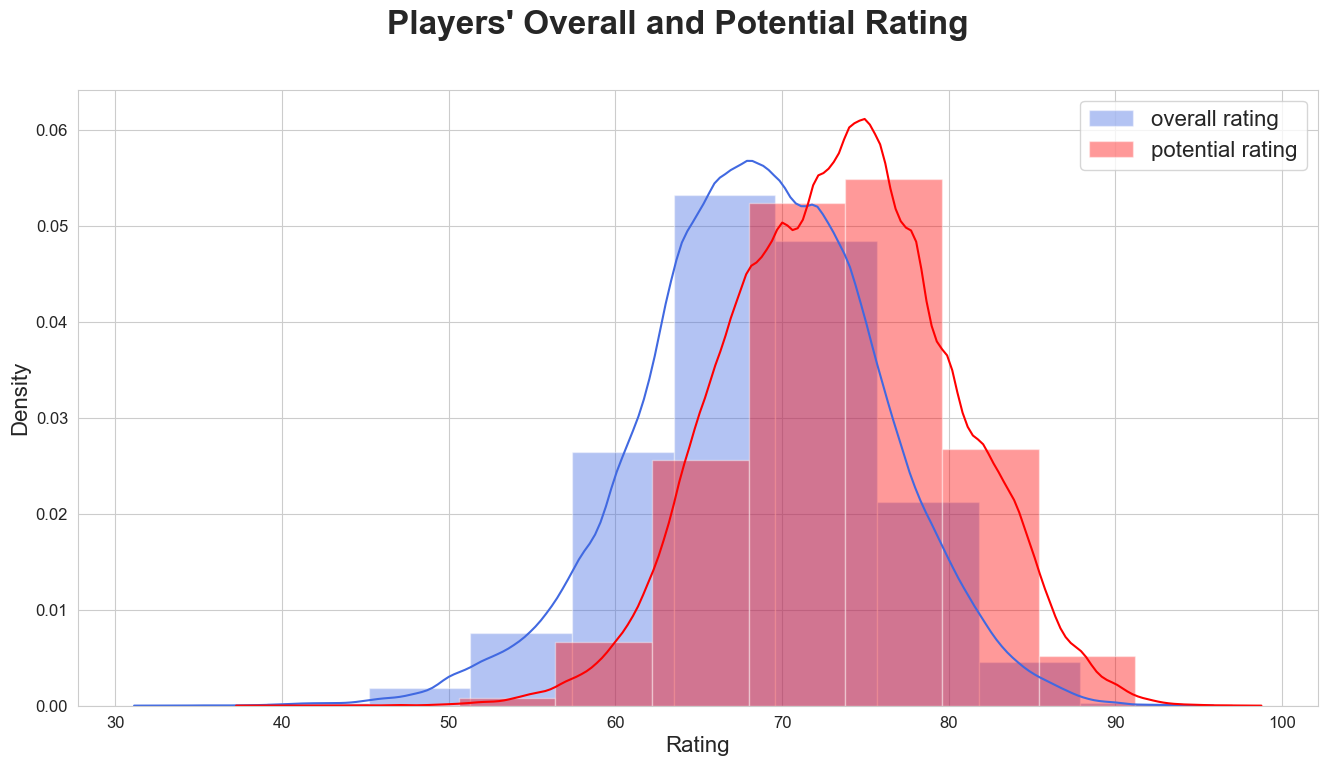

In [233]:
f, ax = plt.subplots(sharey=True, figsize=(16, 8))

f.suptitle(
    "Players' Overall and Potential Rating",
    fontsize=24,
    weight="bold",
)

sns.distplot(
    player_attributes_data["overall_rating"],
    hist=True,
    kde=True,
    bins=10,
    color=color,
    label="overall rating",
)
sns.distplot(
    player_attributes_data["potential"],
    hist=True,
    kde=True,
    bins=10,
    color="r",
    label="potential rating",
)

ax.set_ylabel("Density", fontsize=16)
ax.set_xlabel("Rating", fontsize=16)
plt.setp(ax.get_xticklabels(), fontsize=12)
plt.setp(ax.get_yticklabels(), fontsize=12, visible=True)
ax.legend(fontsize=16)

plt.show();

The range of overall score is quite broad, ranging from a minimum of 33 points to a maximum of 94 points. The majority of soccer players have a score within the range of 64 to 73 points, with an average score of 68.6 points.

In [234]:
avg_diff_rating = round(
    (
        player_attributes_data["potential"] -
        player_attributes_data["overall_rating"]
    ).mean(),
    2,
)

print("Average difference between potential and actual rating: ", avg_diff_rating)


Average difference between potential and actual rating:  4.86


-----
#### Top 3 Players by Season

In [235]:
rating_data = ddb.query(
    """
    SELECT p.player_api_id,
        p.player_name,
        patt.overall_rating,
    EXTRACT(year FROM patt.date::timestamp) AS date
    FROM player_attributes_data AS patt
    JOIN player_data AS p ON patt.player_api_id == p.player_api_id
    """
).to_df()

rating_data = (
    rating_data.groupby(["date", "player_name"])
    .agg(max_rating=("overall_rating", "max"))
    .reset_index()
)
rating_data = (
    rating_data.sort_values(["date", "max_rating"], ascending=False)
    .groupby("date")
    .head(3)
)

rating_data


,date,player_name,max_rating
69741,2016,Manuel Neuer,90.0
70431,2016,Neymar,90.0
66981,2016,Arjen Robben,89.0
63180,2015,Lionel Messi,94.0
60415,2015,Cristiano Ronaldo,93.0
59732,2015,Arjen Robben,90.0
55658,2014,Lionel Messi,94.0
52782,2014,Cristiano Ronaldo,92.0
52068,2014,Arjen Robben,90.0
47945,2013,Lionel Messi,94.0


An investigation was conducted to determine if a correlation exists between a player's physical attributes (measured using BMI) and their overall rating. Data from the year 2016 was utilized for this purpose.

In [236]:
plr_att2016 = player_attributes_data[["player_api_id", "overall_rating"]].where(
    player_attributes_data["date"] >= "2016"
)
plr_att2016 = plr_att2016.dropna()
plr_att2016["player_api_id"] = plr_att2016["player_api_id"].astype("int64")
plr_att2016 = plr_att2016.merge(player_data, on="player_api_id").drop(
    columns=["player_api_id", "player_name", "birthday", "height", "weight"]
)


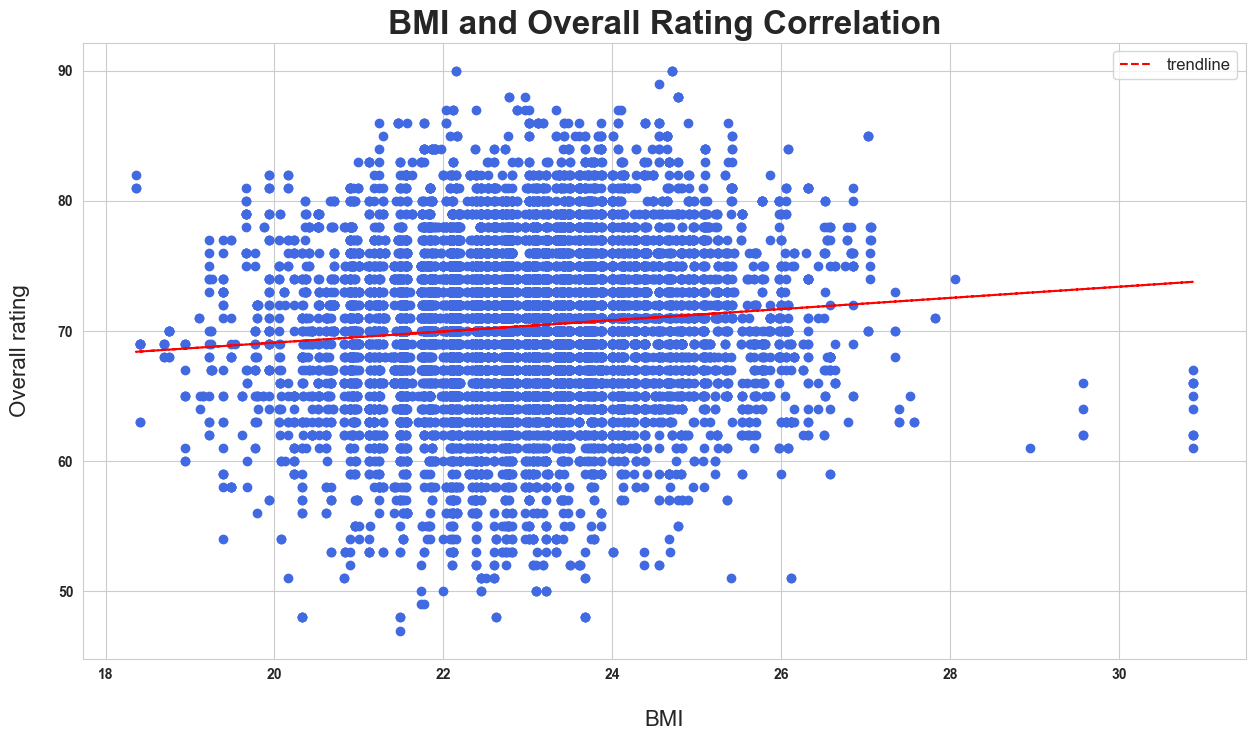

In [237]:
x = plr_att2016["BMI"]
y = plr_att2016["overall_rating"]

fig, ax = plt.subplots(figsize=(15, 8))
ax.scatter(x, y, color=color)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x, p(x), "r--", label="trendline")

plt.xlabel("BMI", size=16, labelpad=20)
plt.ylabel("Overall rating", size=16, labelpad=20)
plt.title("BMI and Overall Rating Correlation", size=24, weight="bold")
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold")

ax.legend(fontsize=12)
plt.show();

Based on the analysis, there appears to be little to no linear correlation between a player's BMI and their overall score.

-----

### Which teams have most win ratios at home and away?

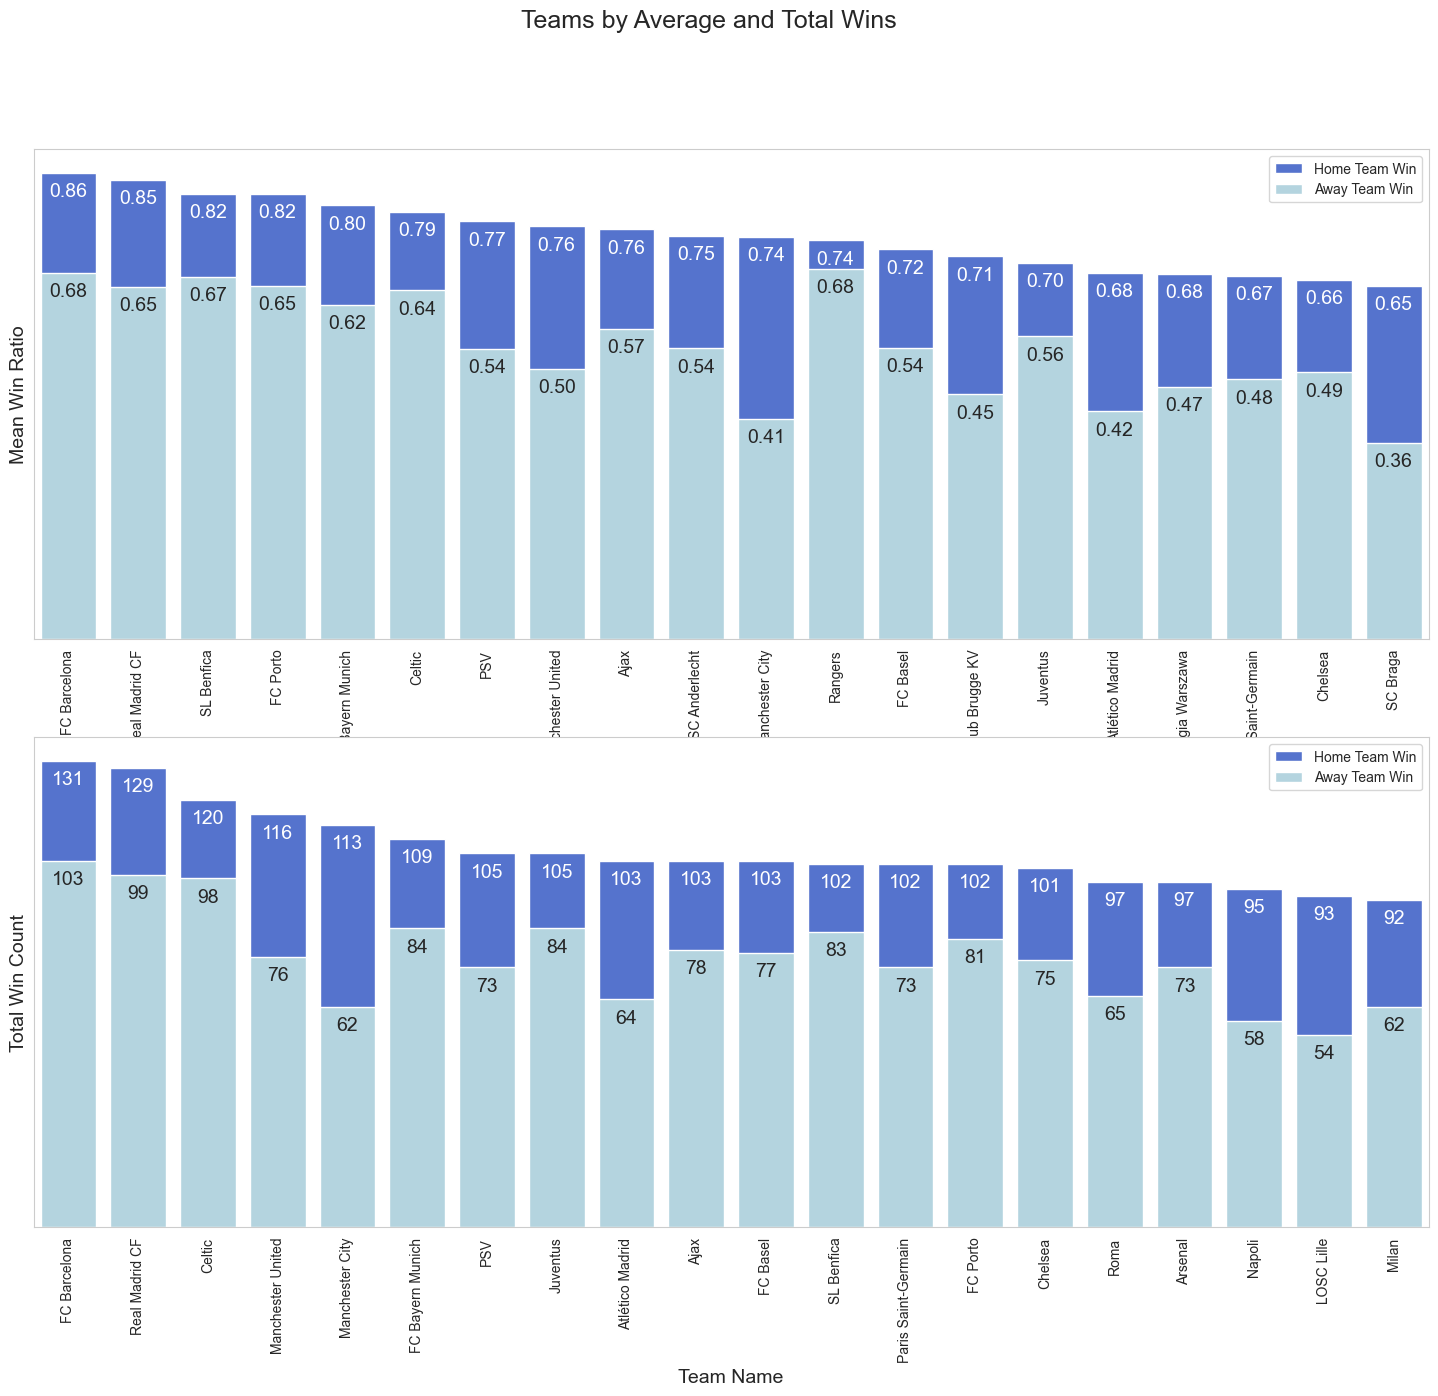

In [238]:
team = team_data.merge(
    match_data[["country_id", "home_team_api_id"]],
    how="left",
    left_on="team_api_id",
    right_on="home_team_api_id",
).drop_duplicates()

team = team.merge(league_data, how="left", on="country_id")


def identify_winner(data):
    if data["home_team_goal"] > data["away_team_goal"]:
        return "home"
    elif data["away_team_goal"] > data["home_team_goal"]:
        return "away"
    else:
        return "draw"


match_data["result"] = match_data.apply(identify_winner, axis=1)

match_results = pd.get_dummies(match_data, columns=["result"])

home_results = match_results.groupby(["home_team_api_id"])[
    ["result_away", "result_draw", "result_home"]
].agg(["mean", "sum"])
home_results.columns = home_results.columns.to_flat_index()

home_results.columns = [
    "home_lose_mean",
    "home_lose_sum",
    "home_draw_mean",
    "home_draw_sum",
    "home_win_mean",
    "home_win_sum",
]

home_results["total_home"] = (
    home_results["home_lose_sum"]
    + home_results["home_draw_sum"]
    + home_results["home_win_sum"]
)

home_results = home_results.reset_index()

away_results = match_results.groupby(["away_team_api_id"])[
    ["result_away", "result_draw", "result_home"]
].agg(["mean", "sum"])
away_results.columns = away_results.columns.to_flat_index()

away_results.columns = [
    "away_win_mean",
    "away_win_sum",
    "away_draw_mean",
    "away_draw_sum",
    "away_lost_mean",
    "away_lose_sum",
]

away_results["total_away"] = (
    away_results["away_win_sum"]
    + away_results["away_draw_sum"]
    + away_results["away_lose_sum"]
)

away_results = away_results.reset_index()

home_away = home_results.merge(
    away_results, how="left", left_on="home_team_api_id", right_on="away_team_api_id"
)

home_away["team_api_id"] = home_away["home_team_api_id"]

home_away = home_away.merge(team, how="left", on="team_api_id")


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(18, 14))
sns.barplot(
    x="team_long_name",
    y="home_win_mean",
    data=home_away.sort_values("home_win_mean", ascending=False).head(20),
    ax=ax1,
    color="royalblue",
    label="Home Team Win",
)
sns.barplot(
    x="team_long_name",
    y="away_win_mean",
    data=home_away.sort_values("home_win_mean", ascending=False).head(20),
    ax=ax1,
    alpha=1,
    color="lightblue",
    label="Away Team Win",
)
ax1.bar_label(ax1.containers[0], fmt="%.2f", padding=-20, color="white", fontsize=14)
ax1.bar_label(ax1.containers[1], fmt="%.2f", padding=-20, fontsize=14)
ax1.set_ylabel("Mean Win Ratio", fontsize=14)
ax1.set_xlabel("Team Name")
ax1.set_yticks([])
ax1.tick_params(axis="x", labelrotation=90)
ax1.legend()

sns.barplot(
    x="team_long_name",
    y="home_win_sum",
    data=home_away.sort_values("home_win_sum", ascending=False).head(20),
    ax=ax2,
    color="royalblue",
    label="Home Team Win",
)
sns.barplot(
    x="team_long_name",
    y="away_win_sum",
    data=home_away.sort_values("home_win_sum", ascending=False).head(20),
    ax=ax2,
    alpha=1,
    color="lightblue",
    label="Away Team Win",
)
ax2.bar_label(ax2.containers[0], padding=-20, color="white", fontsize=14)
ax2.bar_label(ax2.containers[1], padding=-20, fontsize=14)
ax2.set_ylabel("Total Win Count", fontsize=14)
ax2.set_xlabel("Team Name", fontsize=14)
ax2.set_yticks([])
ax2.tick_params(axis="x", labelrotation=90)
ax2.legend()
plt.suptitle("Teams by Average and Total Wins", fontsize=18)

plt.show();

Based on the analysis of win ratios and win numbers for various teams, it can be observed that the top performing teams such as FC Barcelona and Real Madrid tend to perform better at their home stadium. While there are some variations between home and away wins, the difference is not very significant for most teams. It is noteworthy that Manchester City has a considerably better home win ratio of 0.74 compared to an away win ratio of 0.41, which stands out in comparison to its peers. On the other hand, Rangers seems to have the smallest gap in home vs. away win ratios. Overall, the data suggests that teams that are successful at home tend to also perform well as guests. Further analysis can be conducted to explore the relationship between home and away win ratios.

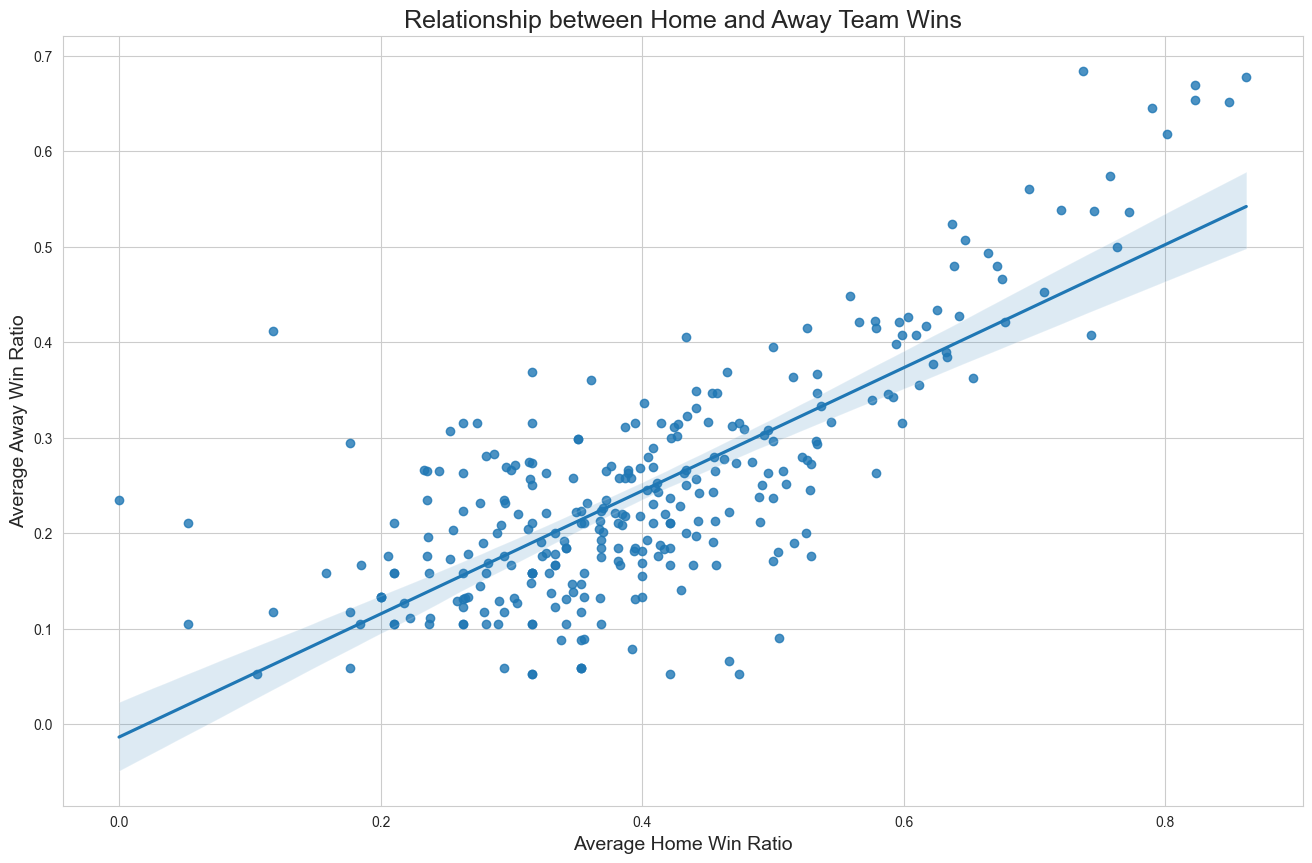

In [239]:
home_away_melt = home_away.melt()
mask = (home_away_melt["variable"] == "home_win_mean") | (
    home_away_melt["variable"] == "away_win_mean"
)
home_away_mean_melt = home_away_melt[mask]
mask = (home_away_melt["variable"] == "home_win_sum") | (
    home_away_melt["variable"] == "away_win_sum"
)
home_away_win_melt = home_away_melt[mask]
fig, ax = plt.subplots(figsize=(16, 10))
sns.regplot(x="home_win_mean", y="away_win_mean", data=home_away)
plt.xlabel("Average Home Win Ratio", fontsize=14)
plt.ylabel("Average Away Win Ratio", fontsize=14)
plt.title("Relationship between Home and Away Team Wins", fontsize=18)
plt.show();

In [240]:
corr = home_away["home_win_mean"].corr(home_away["away_win_mean"])
print(f"The correlation between average home wins and average away wins is: {corr}")

The correlation between average home wins and average away wins is: 0.7656278606023474


The visualization indicates that there is a strong positive correlation between success rates at home and away matches for most teams. However, for top teams, while the away win ratios followed the home win ratios, they were still relatively lower. A majority of the teams in the dataset have win ratios for both home and away games below 0.4. This suggests that the high values observed for top teams are not typical for other teams. Nonetheless, the trends of home and away win ratios for these teams still track each other. In the next step, we will examine the difference between home and away win ratios and perform a hypothesis test to determine if the difference is statistically significant.

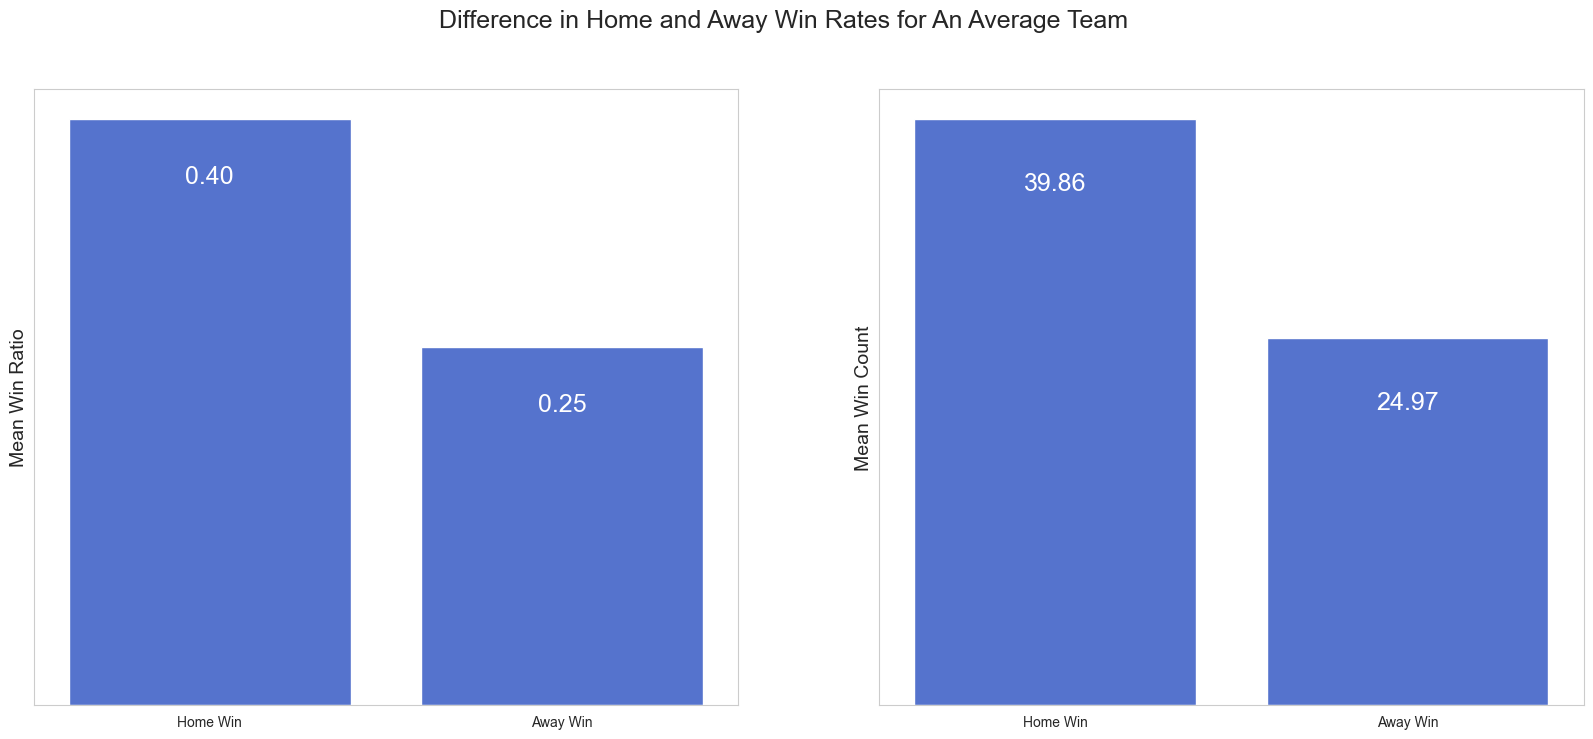

In [241]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
sns.barplot(
    x="variable",
    y="value",
    data=home_away_mean_melt,
    ax=ax1,
    ci=None,
    color="royalblue",
)
sns.barplot(
    x="variable", y="value", data=home_away_win_melt, ax=ax2, ci=None, color="royalblue"
)
ax1.bar_label(ax1.containers[0], fmt="%.2f", color="white", padding=-50, fontsize=18)
ax2.bar_label(ax2.containers[0], fmt="%.2f", color="white", padding=-55, fontsize=18)
ax1.set_ylabel("Mean Win Ratio", fontsize=14)
ax2.set_ylabel("Mean Win Count", fontsize=14)
ax1.set_xlabel("")
ax2.set_xlabel("")
ax1.set_xticks([0, 1], labels=["Home Win", "Away Win"])
ax2.set_xticks([0, 1], labels=["Home Win", "Away Win"])
ax1.set_yticks([])
ax2.set_yticks([])
plt.suptitle("Difference in Home and Away Win Rates for An Average Team", fontsize=18)
plt.show();

The data clearly indicates that teams have a higher chance of winning when playing at their home stadium. 

1. The first graph shows the average win ratios of teams in different settings, with teams playing at home having an average win ratio of around 0.4, almost twice the chance of winning as a guest. 

2. The second graph shows the average number of wins in different settings, with teams playing at home averaging 40 wins, while as a guest they averaged 25 wins. 

These differences are substantial, but to confirm their significance, we need to conduct hypothesis tests that account for potential sources of error.

-----
## Hypothesis Testing

Based on the dataset containing all match results, we aim to investigate whether matches played at home stadiums exhibit a statistically significant higher mean win ratio compared to those played as a guest team.

**Population**: All match results

**Significance Level**: 0.05

**Parameter of Interest**: $\mu_1 - \mu_2$,  Difference of win ratios at home and away

**Null Hypothesis**: $\mu_1 = \mu_2$

**Alternative Hypothesis**: $\mu_1 > \mu_2$

In [242]:
test_stat, p_value = statsmodels.stats.weightstats.ztest(
    home_away["home_win_mean"], home_away["away_win_mean"], alternative="larger"
)
print(
    f"Test statistic: {test_stat}\n\
p-value: {p_value}"
)


Test statistic: 14.126989198099167
p-value: 1.2949112983213457e-45


Based on the extremely low p-value, **we reject the null hypothesis that there is no difference between the average number of wins at home and away games**. The evidence shows that **teams have a significantly higher chance of winning when playing in their home stadium**.

Now, let's apply the same hypothesis test to the number of wins metric to determine if teams have a higher chance of achieving a higher number of wins when playing at home.

Given all the match results in the dataset, is the mean number of wins for a team significantly higher when playing at home compared to playing as a guest team?

**Population**: All match results

**Significance Level**: 0.05

**Parameter of Interest**: $\mu_1 - \mu_2$,  Difference of win count at home and away

**Null Hypothesis**: $\mu_1 = \mu_2$

**Alternative Hypothesis**: $\mu_1 > \mu_2$

In [243]:
test_stat, p_value = statsmodels.stats.weightstats.ztest(
    home_away["home_win_sum"], home_away["away_win_sum"], alternative="larger"
)
print(
    f"Test statistic: {test_stat}\n\
p-value: {p_value}"
)


Test statistic: 6.847020880648412
p-value: 3.770185785200271e-12


Once again, the obtained low p-value provides evidence that supports our hypothesis. It confirms that **there is indeed a statistically significant difference between the average number of wins for matches played at home and those played as a guest team**. Specifically, **teams tend to have significantly higher win numbers when playing at their home stadium**.

-----
### Creating Models

#### Data preparation for modeling

Betting company odds can be useful in predicting the outcome of football matches due to their expert analysis of various factors. However, their limitations include potential bias towards public perception, influence of market demand and betting patterns, and risk of data leaking. To ensure reliability and accuracy, the decision was made to exclude betting company odds from the analysis and focus solely on team and match-related data.

In [244]:
# Selecting columns for modeling

columns = [
    "id",
    "date",
    "match_api_id",
    "home_team_api_id",
    "away_team_api_id",
    "home_team_goal",
    "away_team_goal",
]
home_players = ["home_player_" + str(i) for i in range(1, 12)]
away_players = ["away_player_" + str(i) for i in range(1, 12)]

columns = columns + home_players + away_players
players = home_players + away_players

# Creating a new data frame that includes selected columns from the "match" table

new_match = match_data[columns]
new_match["date"] = pd.to_datetime(new_match["date"])
new_match = new_match.dropna()
new_match = new_match.sort_values(by="date")

# Choosing columns from table Players' attributes

players_att_columns = ["player_api_id", "date", "overall_rating"]

# Creating new data frame with chosen columns from table player attributes

new_player_attributes = player_attributes_data[players_att_columns]
new_player_attributes = new_player_attributes.dropna()
new_player_attributes = new_player_attributes.sort_values(by="date")

# Merging data into one table

for player in players:
    new_match[player] = new_match[player].astype("int64")
    player_rating = new_player_attributes.rename(
        columns={col: f"{col}_{player}" for col in players_att_columns[1:]}
    )

    new_match = pd.merge_asof(
        new_match,
        player_rating,
        left_by=[player],
        right_by=["player_api_id"],
        left_on=["date"],
        right_on=[f"date_{player}"],
        allow_exact_matches=False,
    )

    new_match = new_match.drop(
        [f"date_{player}", player, "player_api_id"], axis=1)

new_match.head()


,id,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,overall_rating_home_player_1,overall_rating_home_player_2,overall_rating_home_player_3,...,overall_rating_away_player_2,overall_rating_away_player_3,overall_rating_away_player_4,overall_rating_away_player_5,overall_rating_away_player_6,overall_rating_away_player_7,overall_rating_away_player_8,overall_rating_away_player_9,overall_rating_away_player_10,overall_rating_away_player_11
0,4770,2008-08-09,483130,9827,7819,2,1,81.0,77.0,69.0,...,67.0,71.0,67.0,66.0,76.0,71.0,70.0,67.0,77.0,58.0
1,4774,2008-08-09,483134,9829,9847,1,0,69.0,65.0,75.0,...,71.0,51.0,77.0,78.0,75.0,75.0,85.0,82.0,61.0,70.0
2,4771,2008-08-09,483131,9746,9831,1,0,73.0,58.0,66.0,...,75.0,73.0,67.0,75.0,74.0,55.0,75.0,67.0,58.0,73.0
3,4775,2008-08-09,483135,8481,8639,0,0,76.0,72.0,78.0,...,70.0,78.0,56.0,77.0,76.0,73.0,76.0,79.0,77.0,69.0
4,4777,2008-08-09,483137,9874,9855,1,2,78.0,62.0,70.0,...,65.0,56.0,68.0,60.0,57.0,59.0,74.0,67.0,79.0,60.0


In [245]:
# Generating a new column 'outcome' that captures the final result of the match
# Home win: 1, Tie: -1, Guest win: 0

conditions = [
    (new_match["home_team_goal"] > new_match["away_team_goal"]),
    (new_match["home_team_goal"] == new_match["away_team_goal"]),
    (new_match["home_team_goal"] < new_match["away_team_goal"]),
]
values = [1, -1, 0]
new_match["outcome"] = np.select(conditions, values)

# Calculating average rating of player in each team

new_match["home_team_avg_rating"] = new_match[
    ["overall_rating_" + player for player in home_players]
].mean(axis=1)
new_match["away_team_avg_rating"] = new_match[
    ["overall_rating_" + player for player in away_players]
].mean(axis=1)

new_match["home_team_avg_rating"] = round(new_match["home_team_avg_rating"], 2)
new_match["away_team_avg_rating"] = round(new_match["away_team_avg_rating"], 2)

new_match.head()


,id,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,overall_rating_home_player_1,overall_rating_home_player_2,overall_rating_home_player_3,...,overall_rating_away_player_5,overall_rating_away_player_6,overall_rating_away_player_7,overall_rating_away_player_8,overall_rating_away_player_9,overall_rating_away_player_10,overall_rating_away_player_11,outcome,home_team_avg_rating,away_team_avg_rating
0,4770,2008-08-09,483130,9827,7819,2,1,81.0,77.0,69.0,...,66.0,76.0,71.0,70.0,67.0,77.0,58.0,1,74.45,69.45
1,4774,2008-08-09,483134,9829,9847,1,0,69.0,65.0,75.0,...,78.0,75.0,75.0,85.0,82.0,61.0,70.0,1,67.91,73.36
2,4771,2008-08-09,483131,9746,9831,1,0,73.0,58.0,66.0,...,75.0,74.0,55.0,75.0,67.0,58.0,73.0,1,64.91,68.82
3,4775,2008-08-09,483135,8481,8639,0,0,76.0,72.0,78.0,...,77.0,76.0,73.0,76.0,79.0,77.0,69.0,-1,69.82,72.45
4,4777,2008-08-09,483137,9874,9855,1,2,78.0,62.0,70.0,...,60.0,57.0,59.0,74.0,67.0,79.0,60.0,0,69.55,65.09


-----
## Building Models for Game Outcome Prediction

In [246]:
# The data for predicting outcome
y = new_match["outcome"]

X_outcome0 = new_match.drop(
    [
        "id",
        "date",
        "match_api_id",
        "home_team_api_id",
        "away_team_api_id",
        "outcome",
        "home_team_goal",
        "away_team_goal",
    ],
    axis=1,
)


In [247]:
x_train, x_test, y_train, y_test = train_test_split(
    X_outcome0, y, test_size=0.2, random_state=42
)


-----
### Logistic Regression

Developing a logistic regression model with the utilization of a Standard Scaler transformer for data preprocessing.

In [248]:
log_model = Pipeline(
    [("scaler", StandardScaler()), ("regression", LogisticRegressionCV())]
)
model = log_model.fit(x_train, y_train)


In [249]:
coef = log_model.score(x_test, y_test)
print(f"Regression coefficient: {round(coef, 3)}.")

intercept = model.named_steps["regression"].intercept_[0]
print(f"Intercept: {round(intercept, 3)}.")

results = (
    pd.DataFrame(model.named_steps["regression"].coef_,
                 columns=x_test.columns).round(3)
).set_index(pd.Index(["tie", "away", "home"]))

results


Regression coefficient: 0.513.
Intercept: -0.172.


,overall_rating_home_player_1,overall_rating_home_player_2,overall_rating_home_player_3,overall_rating_home_player_4,overall_rating_home_player_5,overall_rating_home_player_6,overall_rating_home_player_7,overall_rating_home_player_8,overall_rating_home_player_9,overall_rating_home_player_10,...,overall_rating_away_player_4,overall_rating_away_player_5,overall_rating_away_player_6,overall_rating_away_player_7,overall_rating_away_player_8,overall_rating_away_player_9,overall_rating_away_player_10,overall_rating_away_player_11,home_team_avg_rating,away_team_avg_rating
tie,0.017,0.013,0.023,0.004,0.015,-0.010,0.016,-0.040,-0.008,-0.008,...,0.002,-0.009,-0.004,-0.036,0.009,0.001,0.017,-0.036,0.001,-0.002
away,-0.015,-0.048,-0.060,-0.087,-0.062,-0.059,-0.057,-0.045,-0.046,-0.054,...,0.079,0.078,0.028,0.078,0.057,0.045,0.058,0.043,-0.065,0.061
home,-0.002,0.035,0.037,0.083,0.047,0.068,0.042,0.085,0.054,0.063,...,-0.081,-0.069,-0.025,-0.042,-0.065,-0.046,-0.075,-0.008,0.064,-0.059


The regression coefficient of 0.513 indicates that there is a positive relationship between the predictor variable and the response variable in the regression model. Specifically, for each one-unit increase in the predictor variable,I would expect the response variable to increase by 0.513 units. The intercept of -0.172 represents the expected value of the response variable when the predictor variable is equal to zero. 

In [250]:
predictions = model.predict(x_test)


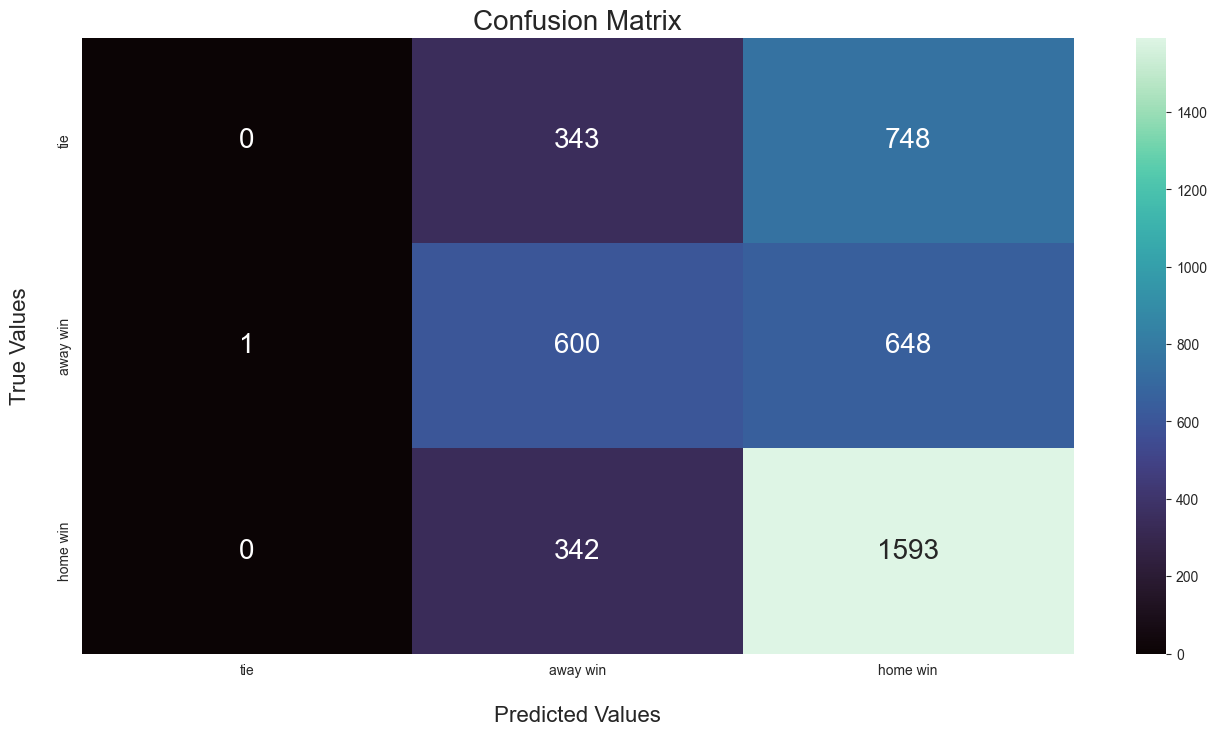

In [251]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    annot_kws={"fontsize": 20},
    fmt="g",
    cmap="mako",
)
plt.xlabel("Predicted Values", size=16, labelpad=20)
plt.ylabel("True Values", size=16, labelpad=20)
plt.title("Confusion Matrix", size=20)

ax.set_xticklabels(["tie", "away win", "home win"])
ax.set_yticklabels(["tie", "away win", "home win"])
plt.show();

The confusion matrix provided shows the classification results of a logistic regression model for a multi-class classification problem with three classes: `tie`, `away win`, and `home win`.

The rows of the confusion matrix represent the true classes, and the columns represent the predicted classes.

1. `tie` class: The model correctly predicted none of the `tie` outcomes. The second column shows that the model predicted 343 outcomes as `away win`, when in fact they were `tie` outcomes. The third column shows that the model predicted 748 outcomes as `home win`, when in fact they were `tie` outcomes.

2. `away win` class: The model correctly predicted 600 `away win` outcomes. The first column shows that the model predicted one outcome as a `tie`, when in fact it was an `away win`. The third column shows that the model predicted 648 outcomes as `home win`, when in fact they were `away win` outcomes.

3. `home win` class: The model correctly predicted 1593 `home win` outcomes. The second column shows that the model predicted 342 outcomes as `away win`, when in fact they were `home win` outcomes. The first column shows that the model predicted no outcomes as `tie`, when in fact they were `home win` outcomes.

In summary, the confusion matrix indicates that the model performed well in predicting `away win` and `home win` outcomes but struggled to correctly predict `tie` outcomes. 

This statement suggests that a predictive model has been built, which is showing a tendency to predict home wins more frequently than the actual occurrence of home wins in the dataset. This could be due to the fact that home wins occur more frequently in the dataset, leading the model to make more predictions in favor of home wins.

In [252]:
print(
    classification_report(
        y_test, predictions, target_names=["tie", "away win", "home win"]
    )
)

              precision    recall  f1-score   support

         tie       0.00      0.00      0.00      1091
    away win       0.47      0.48      0.47      1249
    home win       0.53      0.82      0.65      1935

    accuracy                           0.51      4275
   macro avg       0.33      0.43      0.37      4275
weighted avg       0.38      0.51      0.43      4275



The classification report shows the performance of a model in predicting three classes (`tie`, `away win`, `home win`). The precision for class `tie` is 0.00, meaning that when the model predicted class `tie`, it was always wrong. The recall for class `tie` is also 0.00, meaning that the model failed to correctly identify any instances of class `tie`. The precision and recall for class `away win` are 0.47 and 0.48 respectively, which indicates that the model predicted class `away win` with moderate accuracy. The precision and recall for class `home win` are 0.53 and 0.82 respectively, indicating that the model was better at predicting class `home win`. The f1-score is the harmonic mean of precision and recall, and is a measure of overall performance, with higher values indicating better performance. The accuracy of the model overall is 0.51.

I'll attempt different approach to predict the the outcome of the match.

-----
### Support Vector Clasification

Developing a SVC model with the utilization of a Standard Scaler transformer for data preprocessing.

In [253]:
x_train, x_test, y_train, y_test = train_test_split(
    X_outcome0, y, test_size=0.2, random_state=42
)


In [254]:
svc_model = Pipeline([("scaler", StandardScaler()),
                     ("svm", SVC(probability=True))])

# Fitting the model on the training set
model = svc_model.fit(x_train, y_train)
predictions = model.predict(x_test)


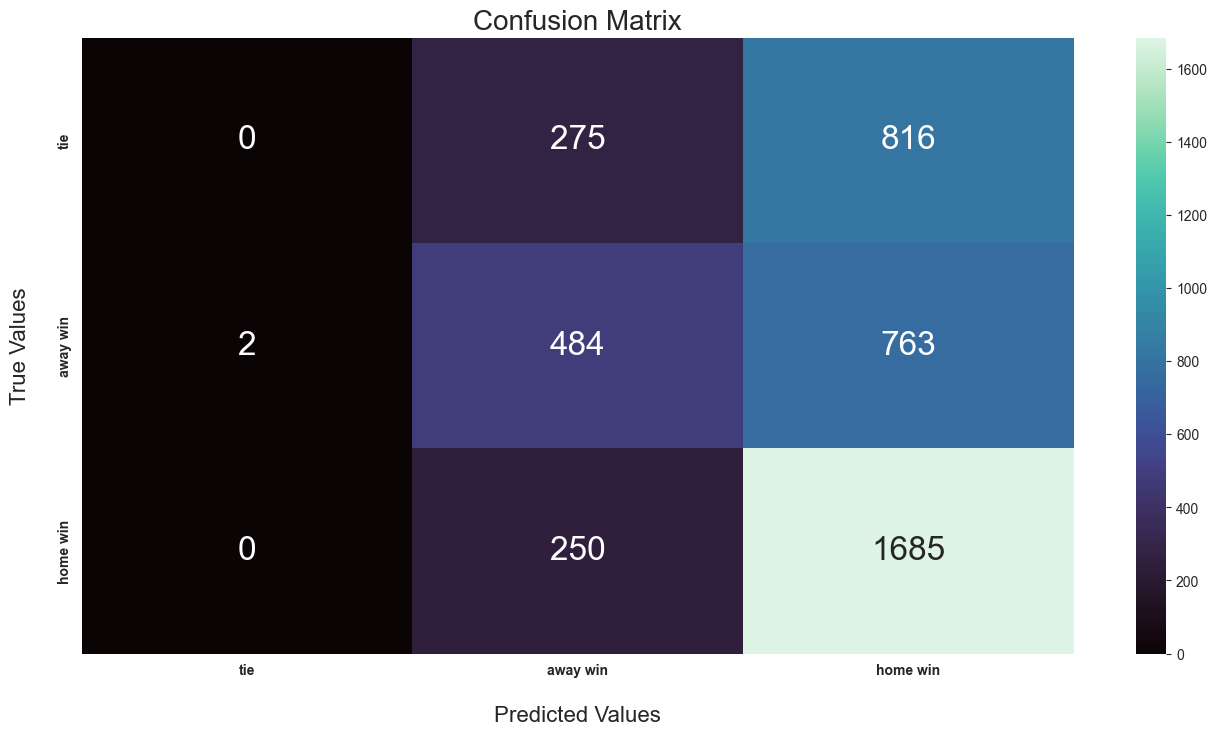

In [255]:
fig, ax = plt.subplots(figsize=(16, 8))
sns.heatmap(
    data=confusion_matrix(y_test, predictions),
    annot=True,
    annot_kws={"fontsize": 24},
    fmt="g",
    cmap="mako",
)
plt.xlabel("Predicted Values", size=16, labelpad=20)
plt.ylabel("True Values", size=16, labelpad=20)
plt.title("Confusion Matrix", size=20)
plt.yticks(fontweight="bold")
plt.xticks(fontweight="bold")
ax.set_xticklabels(["tie", "away win", "home win"])
ax.set_yticklabels(["tie", "away win", "home win"])
plt.show();

1. The top row of the matrix corresponds to the true negatives (TN), which in this case is the number of times the model predicted `tie` or `away win` and the actual result was `home win`. There are 0 true negatives for `tie`, 275 true negatives for `away win`, and 816 true negatives for `home win`.

2. The second row of the matrix corresponds to the false negatives (FN), which is the number of times the model predicted `home win` but the actual result was `tie` or `away win`. There are 2 false negatives for `tie`, 484 false negatives for `away win`, and 763 false negatives for `home win`.

3. The third row of the matrix corresponds to the true positives (TP), which is the number of times the model predicted `tie`, `away win` or `home win` and the actual result was also `tie`, `away win`, or `home win`. There are 0 true positives for `tie`, 250 true positives for `away win`, and 1685 true positives for `home win`.

The diagonal of the matrix, from top left to bottom right, represents the accurate predictions, also called true predictions. The off-diagonal elements represent the inaccurate predictions.

In [256]:
print(
    classification_report(
        y_test, predictions, target_names=["tie", "away win", "home win"]
    )
)

              precision    recall  f1-score   support

         tie       0.00      0.00      0.00      1091
    away win       0.48      0.39      0.43      1249
    home win       0.52      0.87      0.65      1935

    accuracy                           0.51      4275
   macro avg       0.33      0.42      0.36      4275
weighted avg       0.37      0.51      0.42      4275



Looking at the report, the model has a low precision and recall for class `tie`, meaning it is not good at predicting that class. 

For class `away win`, the precision is relatively high but the recall is low, indicating that the model is better at correctly predicting negative instances but not as good at predicting positive instances. 

For class `home win`, both precision and recall are relatively high, which means that the model is good at predicting positive instances for this class. Overall, the model has an accuracy of 51% on the dataset.

_Comparing **Support Vector Classification**" model to **Logisitc Regression** model we observe that results are predictions are slighly worse for `away win` and almost the same for `home win`. The predictions of `tie` is bad in both models._

-----
### Forecasting the quantity of scored goals

In [257]:
y = new_match[["home_team_goal", "away_team_goal"]]

X_goals = new_match.drop(
    [
        "id",
        "date",
        "match_api_id",
        "away_team_api_id",
        "home_team_api_id",
        "outcome",
        "home_team_goal",
        "away_team_goal",
    ],
    axis=1,
)


How many goals are there in each category?

In [258]:
htg = pd.DataFrame(y["home_team_goal"].value_counts())
atg = pd.DataFrame(y["away_team_goal"].value_counts())

team_goals = pd.merge(htg, atg, how="outer", left_index=True, right_index=True)

team_goals


,home_team_goal,away_team_goal
0,4803,7054.0
1,6875,7386.0
2,5228,4274.0
3,2731,1801.0
4,1173,609.0
5,382,179.0
6,137,56.0
7,31,9.0
8,8,5.0
9,4,1.0


As the majority of goals fall within the range of 0 to 5, I've made the decision to focus solely on this subset of data. This meant that I excluded any data outside of this range, as it was deemed irrelevant for the purposes of my analysis. However, it's important to note that due to the small sample size, the accuracy of the results may be limited.

In [259]:
drop_goals = y[(y["home_team_goal"] > 5) | (y["away_team_goal"] > 5)].index

y = y.drop(index=drop_goals)
X_goals = X_goals.drop(index=drop_goals)


In [260]:
x_train, x_test, y_train, y_test = train_test_split(
    X_goals, y, test_size=0.2, random_state=42
)


In a soccer match, multioutput could be used to predict the number of goals scored by each team. The model would need to make two predictions, one for each team, and the output would have two dimensions.

In [261]:
# Developing an SVM model that utilizes multioutput
mlt_svc_model = Pipeline(
    [("scaler", StandardScaler()), ("svm", MultiOutputClassifier(SVC()))]
)

# Fit the model on the training set
model = mlt_svc_model.fit(x_train, y_train)
predictions = pd.DataFrame(model.predict(x_test))


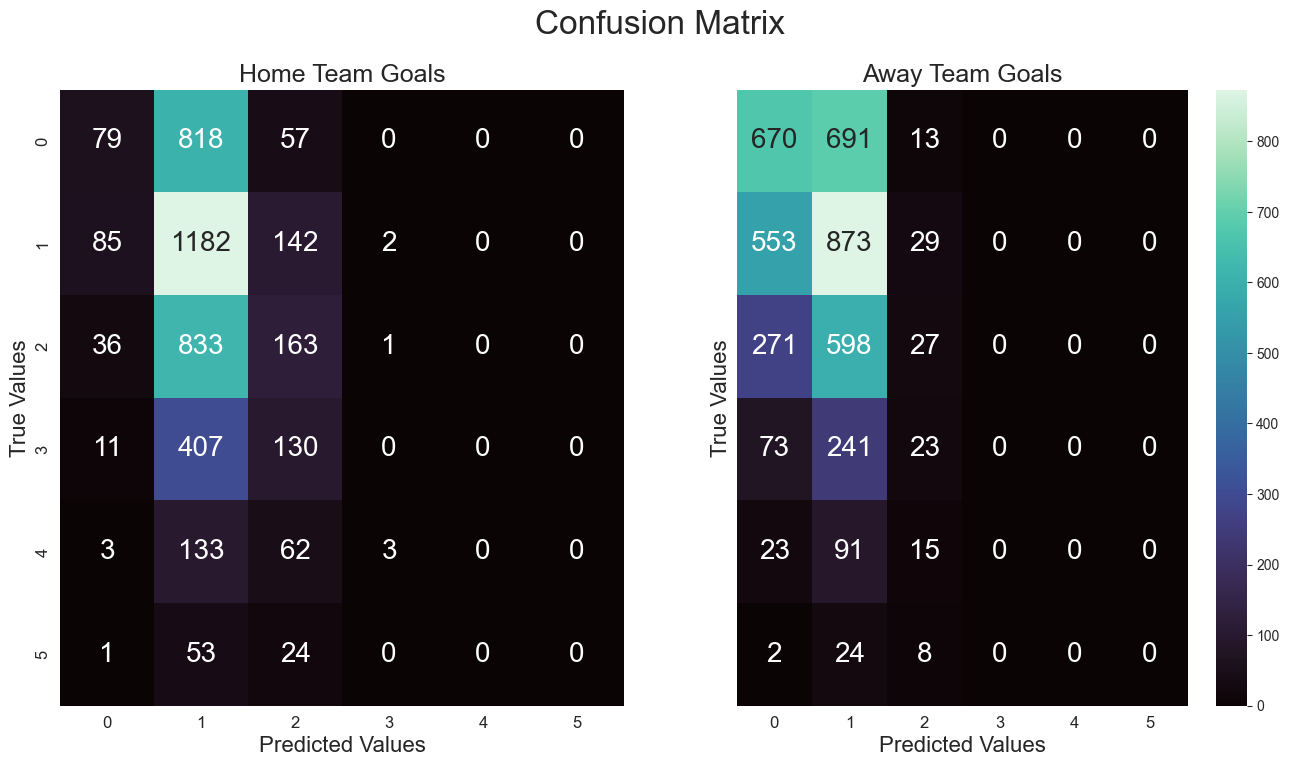

In [262]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8), sharey=True)

fig.suptitle("Confusion Matrix", fontsize=24)


sns.heatmap(
    data=confusion_matrix(y_test.iloc[:, 0], predictions.iloc[:, 0]),
    annot=True,
    annot_kws={"fontsize": 20},
    fmt="g",
    cmap="mako",
    ax=ax1,
    cbar=False,
)

ax1.set_title("Home Team Goals", fontsize=18)
ax1.set_ylabel("True Values", fontsize=16)
ax1.set_xlabel("Predicted Values", fontsize=16)
plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.setp(ax1.get_yticklabels(), fontsize=12, visible=True)


sns.heatmap(
    data=confusion_matrix(y_test.iloc[:, 1], predictions.iloc[:, 1]),
    annot=True,
    annot_kws={"fontsize": 20},
    fmt="g",
    cmap="mako",
    ax=ax2,
)

ax2.set_title("Away Team Goals", fontsize=18)
ax2.set_ylabel("True Values", fontsize=16)
ax2.set_xlabel("Predicted Values", fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=12)
plt.setp(ax2.get_yticklabels(), fontsize=12, visible=True)
plt.show();

#### Home Team Goals Confusion Matrix

- Class `0 goals`: Out of 954 instances, 79 were predicted as class 0, while the remaining 875 were misclassified as belonging to other classes.
- Class `1 goal`: Out of 1411 instances, 1182 were correctly predicted as class 1, while 85 were misclassified as class 0, 142 were misclassified as class 2, and 2 were misclassified as class 3.
- Class `2 goals`: Out of 1033 instances, 163 were correctly predicted as class 2, while 36 were misclassified as class 0 and 833 were misclassified as other classes.
- Class `3 goals`: Out of 548 instances, none were correctly predicted as class 3, while 11 were misclassified as class 0, 407 were misclassified as class 1, and 130 were misclassified as class 2.
- Class `4 goals`: Out of 201 instances, none were correctly predicted as class 4, while 3 were misclassified as class 0, 133 were misclassified as class 1, 62 were misclassified as class 2, and 3 were misclassified as class 3.
- Class `5 goals`: Out of 78 instances, none were correctly predicted as class 5, while 1 was misclassified as class 0 and 53 were misclassified as class 1, and 24 were misclassified as class 2.

#### Home Team Goals Classification Report

In [263]:
print(
    classification_report(
        y_test.iloc[:, 0],
        predictions.iloc[:, 0],
        target_names=[
            "0 goals",
            "1  goal",
            "2 goals",
            "3 goals",
            "4 goals",
            "5 goals",
        ],
    )
)


              precision    recall  f1-score   support

     0 goals       0.37      0.08      0.14       954
     1  goal       0.35      0.84      0.49      1411
     2 goals       0.28      0.16      0.20      1033
     3 goals       0.00      0.00      0.00       548
     4 goals       0.00      0.00      0.00       201
     5 goals       0.00      0.00      0.00        78

    accuracy                           0.34      4225
   macro avg       0.17      0.18      0.14      4225
weighted avg       0.27      0.34      0.24      4225



Looking at the results, the model performs relatively well for class 1, with a precision of 0.35 and a high recall of 0.84, meaning that the model correctly identifies a high proportion of samples belonging to this class. However, for classes 0, 2, 3, 4, and 5, the model performs poorly with low precision, recall, and F1-scores, meaning that it struggles to correctly identify samples in those classes. The overall accuracy of the model is 0.34, meaning that it correctly predicts the class of 34% of the samples. 

#### Away Team Goals Confusion Matrix

- Class `0 goals`: Out of 1374 instances, 670 were correctly classified as class 0, 691 were incorrectly classified as class 1, and 13 were incorrectly classified as class 2.
- Class `1 goal`: Out of 1455 instances, 553 were incorrectly classified as class 0, 873 were correctly classified as class 1, and 29 were incorrectly classified as class 2.
- Class `2 goals`: Out of 896 instances, 271 were incorrectly classified as class 0, 598 were incorrectly classified as class 1, and 27 were correctly classified as class 2.
- Class `3 goals`: Out of 337 instances, 73 were incorrectly classified as class 0, 241 were incorrectly classified as class 1, and 23 were correctly classified as class 3.
- Class `4 goals`: Out of 129 instances, 23 were incorrectly classified as class 0, 91 were incorrectly classified as class 1, and 15 were correctly classified as class 4.
- Class `5 goals`: Out of 34 instances, 2 were incorrectly classified as class 0, 24 were incorrectly classified as class 1, and 8 were correctly classified as class 5.

#### Away Team Goals Classification Report

In [264]:
print(
    classification_report(
        y_test.iloc[:, 1],
        predictions.iloc[:, 1],
        target_names=[
            "0 goals",
            "1  goal",
            "2 goals",
            "3 goals",
            "4 goals",
            "5 goals",
        ],
    )
)


              precision    recall  f1-score   support

     0 goals       0.42      0.49      0.45      1374
     1  goal       0.35      0.60      0.44      1455
     2 goals       0.23      0.03      0.05       896
     3 goals       0.00      0.00      0.00       337
     4 goals       0.00      0.00      0.00       129
     5 goals       0.00      0.00      0.00        34

    accuracy                           0.37      4225
   macro avg       0.17      0.19      0.16      4225
weighted avg       0.31      0.37      0.31      4225



Looking at the precision scores, I see that the model performs best at predicting class 0 with a precision of 0.42, and worst at predicting classes 3, 4, and 5, where the precision scores are all 0.0. This means that when the model predicts a label for classes 3, 4, and 5, it is always incorrect.

The recall score shows that the model performs well at identifying class 0 and 1, with recall scores of 0.49 and 0.60, respectively. However, the model struggles to identify classes 2, 3, 4, and 5, with recall scores all below 0.1. This means that the model is not able to correctly identify many of the instances of these classes.

The F1-score is a measure of the model's overall performance, taking both precision and recall into account. The weighted average F1-score is 0.31, which is low and suggests that the model is not performing well overall.

The support column shows the number of instances in each class. The accuracy score, which measures the overall percentage of correctly classified instances, is 0.37. The macro average F1-score is 0.16, which is also low and suggests that the model's performance is poor across all classes.

The model operates on a per-team basis, generating individual scores for each team. Analysis of the model's output indicates that a majority of the predicted scores are classified into categories 0 and 1, which happen to be the most frequently occurring categories. While the model shows some promise in predicting match outcomes, it suffers from significant limitations that may arise from a range of factors, including feature selection and modeling methodology. 

_**Ultimately, my final model was _reasonably effective_ in predicting certain matches, while falling short in others. Given the stochastic nature of soccer matches, I have concluded that the model's performance was not extremely low.**_


## Conclusions

My analysis has uncovered several noteworthy findings. 

1. I have identified a strong correlation between top scoring players and those with high overall ratings. This pattern holds true in a majority of cases and I also observe that elite players tend to maintain their position at the top of the rankings for extended periods of time.

2. My study has revealed a wide range of physical features amongst soccer players. This includes but is not limited to, height, weight, and muscular composition. These factors may impact player performance and might be taken into account when modeling.

3. I have found that home advantage is a real phenomenon in soccer and can significantly influence the accuracy of models. I recommend that any analysis or predictive models related to soccer outcomes should consider home advantage as a potential variable to be factored in.

4. I have created models that are capable of predicting home wins and the probability of scoring 0 or 1 goals in a match. I have used historical data from soccer matches and statistical techniques to develop this model. The model's performance was evaluated using various metrics, and it was found to have a reasonable level of accuracy. Based on the results, it can be concluded that the model can be used by soccer enthusiasts, bettors, and analysts to make informed decisions about upcoming matches. The model provides valuable insights into the likelihood of a home win and the probability of a team scoring 0 or 1 goals. This information can be used to place bets or make more informed predictions about the outcome of a match.


## Proposed Improvements

My analysis has yielded several suggestions for improving the current approach. 

1. I recommend a more advanced content analysis, particularly with respect to synthesizing data for quality categories that are of lower abundance. This will enable us to gain a more nuanced understanding of the underlying patterns and trends in the data, and may lead to more accurate models.

2. I suggest experimenting with non-linear models, which have the potential to capture more complex relationships between variables. This may be particularly useful in cases where the current models are not able to fully capture the complexity of the data.

3. I recommend utilizing additional features for modeling, particularly those that can be derived from the 'Team Attributes' table. This will enable us to incorporate more information into my models and may help to improve their accuracy.

4. I propose gathering more data related to the accuracy of scoring, which can help us to better understand the impact of various factors on match outcomes. This will also enable us to assess the effectiveness of my models more rigorously.

5. Having more features I'd suggest exploring the use of principal component analysis (PCA) for feature reduction. This technique can help to identify the most important features for modeling, which may be particularly useful when dealing with large datasets that contain many variables.

Overall, these suggestions aim to enhance the accuracy and effectiveness of models, and to provide a more robust foundation for analyzing soccer data.

Looker Studio Charts: [European Football Leagues Goals](https://lookerstudio.google.com/reporting/7be243cd-5282-4fc1-bc10-4a356f5c034e)